# Coding project - classification of medical images

The goal of this project is to evaluate your capacity to design a deep learning pipeline for **image** analysis on a real case study, from data processing to interpretation of the model's result. The project accounts for 60% of the course's grade, and will be evaluated as follows:

Criterion | Weight |Details
-------------------|------------------|----------
Quality of the oral  | 30% | Clarity, discussion, ideas for improvement
Coding quality | 30% | Relevant methods, advanced techniques, quality of implementation, reproducibility
Interpretation | 30% | Relevance and quality of interpretation, quality of visual representations
Performance | 10% | Final performance on the classification task of interest

# Predicting invasive ductal carcinoma in tissue slices

## Motivations

Breast cancer is the most common form of cancer in women, and Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. Accurately identifying IDC is an important clinical task, to assign an aggressiveness rate to a sample. To identify IDC, a biopsy is often done to remove small tissue samples. Then, the tissue sample is visualized by a pathologist, who makes the diagnosis. In the past 10 years, Deep learning tools have been developed to accelerate the time to diagnosis, with automated models which analyze digital images of tissue samples in order to propose a diagnosis. However, several technical challenges remain, in particular to obtain more robust deep learning tools.

## Data set

The original dataset consisted of 162 scanned images of Breast Cancer (BCa) samples. These images are of very high resolution, and thus extremely heavy. Thus, 277,524 patches of size 50 x 50 were extracted, resulting in 198,738 IDC negative and 78,786 IDC positive samples. The original study can be found [here](https://pubmed.ncbi.nlm.nih.gov/27563488/), and examples of resulting image patches are shown below.

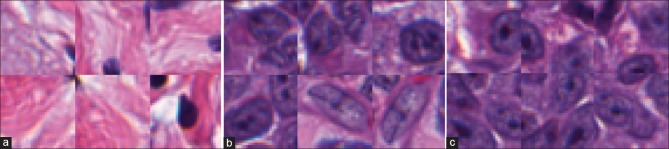




## Set up



Don't forget to change the device to GPU T4

In [1]:
import torch

### TODO: set the device to "cuda" if a GPU is available, "CPU" otherwise

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Download the data set using the following code, and check the variable `path` to see where the downloaded folder is located.

In [2]:

import torch
from PIL import Image
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
import kagglehub
from glob import glob
import cv2
import matplotlib.pyplot as plt

import random
import seaborn as sns
from matplotlib.colors import ListedColormap


import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV

##Cellule pour la reproductibilité

In [3]:

def set_reproducibility(seed=42):
    """
    Verrouille toutes les sources d'aléatoire (Python, Numpy, PyTorch, GPU).
    """
    # Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # Si multi-GPU

    # Forcer le déterminisme des algorithmes de convolution (cuDNN)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Reproductibilité activée avec la graine : {seed}")
set_reproducibility(42)


Reproductibilité activée avec la graine : 42


In [4]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-histopathology-images' dataset.
Path to dataset files: /kaggle/input/breast-histopathology-images


Load the data set, visualize a few samples, store the images and labels in python obkects.

In [5]:
# Data download should take ~6min
data = glob('/kaggle/input/breast-histopathology-images/**/*.png', recursive=True)

KeyboardInterrupt: 

In [ ]:
for i in data[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(200,200))
    plt.imshow(img_1,cmap='binary')
    plt.show()

In [ ]:
images=[]
labels=[]
# We only consider the 4,000 first images for the sake of computational time
# Feel free to reduce or increase the number of images depending on your resources
idx_choose = np.random.choice(np.arange(len(data)), 1000, replace=False).tolist()

for idx in idx_choose:
    i = data[idx]
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(100,100))
        images.append(img_1)
        labels.append(label)


In [ ]:
print(f"size of images:{np.array(images).shape}")

size of images:(1000, 100, 100, 3)


## Work by yourself

The goal of this project is for you to develop autonomously a whole deep learning pipeline to classify the patch images into IDC negative (0) and IDC positive (1). To complete the assignment, you are required to address the following points:

***Set-up your pipeline:***
- Explore the data with summaries and visualization to understand whether classes are balanced, what the images look like, etc.
- Split the data into training, test and validation sets.
- Create PyTorch data sets containing images and labels.
- Be careful with the format of your image objects, sometimes we need to store them as arrays, sometimes as PIL images.
- Train a first model to predict IDC classification and evaluate it on the validation data.

***Improve the performance of your model:***
- Experiment with different network architectures and with pre-trained models.
- Data augmentation works well to improve the performance of vision classifiers. Check the [documentation](https://docs.pytorch.org/vision/main/transforms.html) to learn how to include data augmentation in your PyTorch `transform`.
- Tune the hyperparameters of the different models and compare their performance using different evaluation metrics.

***Interpret your results:***
- Implement an interpretation analysis using one or several tools of your choice. For instance, you can check the documentation of the python implementations of [Grad-CAM](https://pypi.org/project/pytorch-gradcam/), [LIME](https://pypi.org/project/lime/) and [SHAP](https://pypi.org/project/shap/).
- Provide visual representations of the interpretation analysis, for instance on a few chosen images, and comment the results.
- Provide a general conclusion to your project which summarizes your results and findings, as well as possible ideas of improvement.

#1. Introduction


---


Le cancer du sein représente l'un des cancers les plus fréquents chez la femme et constitue un enjeu majeur de santé publique. Le diagnostic repose notamment sur l'analyse histopathologique de coupes de tissu mammaire, au cours de laquelle le pathologiste recherche des signes de malignité, tels que la présence d'un carcinome canalaire infiltrant (Invasive Ductal Carcinoma, IDC).

Cette analyse visuelle est cependant une tâche complexe, chronophage et soumise à une certaine variabilité inter-observateurs. Dans ce contexte, les méthodes d'intelligence artificielle, et en particulier le **Deep Learning**, offrent une opportunité intéressante pour assister les cliniciens dans la détection de lésions cancéreuses à partir d'images de biopsie numérisées.

L'objectif de ce projet est de développer et d'évaluer un pipeline complet de classification d'images histopathologiques de sein. Plus précisément, nous cherchons à distinguer des patchs d'images IDC (présence de cancer) et non-IDC (absence de cancer), à l'aide de **réseaux de neurones convolutionnels**. Nous mettons en place :

*  un modèle de base (simple CNN) servant de référence,
*  un modèle amélioré basé sur le transfert de connaissances (ResNet18 pré-entraîné),
* et une analyse d'interprétabilité permettant de visualiser les régions de l'image qui influencent le plus la décision du modèle.


---



#2. Préparation des données: Importations, Chargement et Séparation par Patient

En histopathologie, un même patient fournit des centaines de "patchs" (images). Ces patchs partagent des caractéristiques biologiques et techniques (même coloration, même texture de tissu). Si nous séparons aléatoirement les images, le modèle retrouvera des morceaux du Patient A dans le Train et dans le Test. Il n'apprendra pas à reconnaître le cancer, mais à reconnaître le Patient A. En séparant par ID Patient, nous garantissons que le modèle est évalué sur des patients qu'il n'a jamais vus, simulant ainsi un vrai cas clinique.

In [ ]:
print("Inspection des 5 premiers fichiers ")
for i, filepath in enumerate(data[0:5]):
    filename = os.path.basename(filepath)
    print(f"Fichier {i+1} : {filename}")

Inspection des 5 premiers fichiers 
Fichier 1 : 10295_idx5_x1351_y1101_class0.png
Fichier 2 : 10295_idx5_x1501_y501_class0.png
Fichier 3 : 10295_idx5_x1501_y1101_class0.png
Fichier 4 : 10295_idx5_x451_y901_class0.png
Fichier 5 : 10295_idx5_x801_y451_class0.png


Les fichiers sont en format **patient id_Index ID_Coordonnée X_Coordonnée X_classe.png**


*   **Patient ID :** c'est l'identifiant unique du patient,
*   **Index ID:** C'est l'identifiant de la biopsie spécifique pour ce patient, (un patient peut avoir plusieurs prélèvements),
*  **Coordonnée X:** c'est la position horizontale du patch,
*  **Coordonnée Y:** c'est la position verticale du patch.



In [ ]:

random.seed(42)
random.shuffle(data)
data1 = data[:30000] # si j'ai envie de diminiuer ou d'augmenter la taille de l'echantillon


# Construction du DataFrame
records = []
print("Construction du DataFrame et extraction des IDs patients...")
for filepath in data1:
    filename = os.path.basename(filepath)
    try:
        patient_id = filename.split('_')[0]
        if 'class1' in filename:
            target = 1
        elif 'class0' in filename:
            target = 0
        else:
            continue

        records.append({
            'path': filepath,
            'patient_id': patient_id,
            'target': target
        })
    except Exception:
        continue

dframe = pd.DataFrame(records)
print(f"DataFrame construit. {len(dframe)} images , {dframe['patient_id'].nunique()} patients.")




Construction du DataFrame et extraction des IDs patients...
DataFrame construit. 30000 images , 279 patients.


### Structuration des données et séparation train / validation / test

 Afin d'évaluer rigoureusement la capacité de généralisation de nos modèles, nous avons partitionné les données en trois sous-ensembles distincts :
*  un ensemble d'entraînement (70 %) ;
*   Un ensemble de validation (15 %) ;
*   Un ensemble de test (15 %)

Cette séparation a été réalisée en se basant sur l'identifiant des patients (via la fonction train_test_split de scikit-learn), et non de manière aléatoire sur l'ensemble des images. Cette approche méthodologique est cruciale en imagerie médicale pour prévenir la fuite de données (data leakage). En effet, les patchs issus d'un même patient présentent de fortes similitudes visuelles (texture, coloration). Un mélange aléatoire aurait entraîné la présence d'images du même patient à la fois dans l'entraînement et dans le test, ce qui aurait faussé l'évaluation en testant la capacité du modèle à reconnaître un patient plutôt qu'à détecter la pathologie.

L'ensemble de validation est utilisé pour le suivi des métriques en cours d'apprentissage et la sélection du meilleur modèle (basé sur l'AUC), tandis que l'ensemble de test est conservé intact jusqu'à la fin pour fournir une estimation objective et non biaisée des performances cliniques finales

In [ ]:
patient_ids = dframe['patient_id'].unique() #le split sur des patients
train_ids, test_val_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, random_state=42)

# Création des DataFrames correspondant
train_df = dframe[dframe['patient_id'].isin(train_ids)].copy()
val_df = dframe[dframe['patient_id'].isin(val_ids)].copy()
test_df = dframe[dframe['patient_id'].isin(test_ids)].copy()

print(f"Train : {len(train_df)} images")
print(f"Val   : {len(val_df)} images")
print(f"Test  : {len(test_df)} images")

Train : 20770 images
Val   : 4397 images
Test  : 4833 images


##2.1 Hétérogénéité des données

L'histogramme ci-dessous montre que la contribution de chaque patient est inégale. Certains patients fournissent des centaines d'images, d'autres très peu. Cela renforce la nécessité de faire un split basé sur les patients et non sur les images, pour éviter que les 'gros' patients ne dominent l'apprentissage. Nous avons vérifié informatiquement qu'aucun patient présent dans l'ensemble d'entraînement ne se retrouve dans l'ensemble de test (intersection = 0). Cela garantit l'intégrité de notre évaluation.

Si nous ne séparons pas par patient, le modèle triche en mémorisant les caractéristiques techniques (couleur, contraste) des patients surreprésentés (les 'gros' patients de l'histogramme) qu'il a déjà vus dans l'entraînement. En isolant totalement les patients du Test, nous simulons un vrai diagnostic clinique sur un nouveau patient jamais vu


Statistiques des patchs par patient :
Minimum de patchs/patient : 6
Maximum de patchs/patient : 279
Moyenne de patchs/patient : 107.53


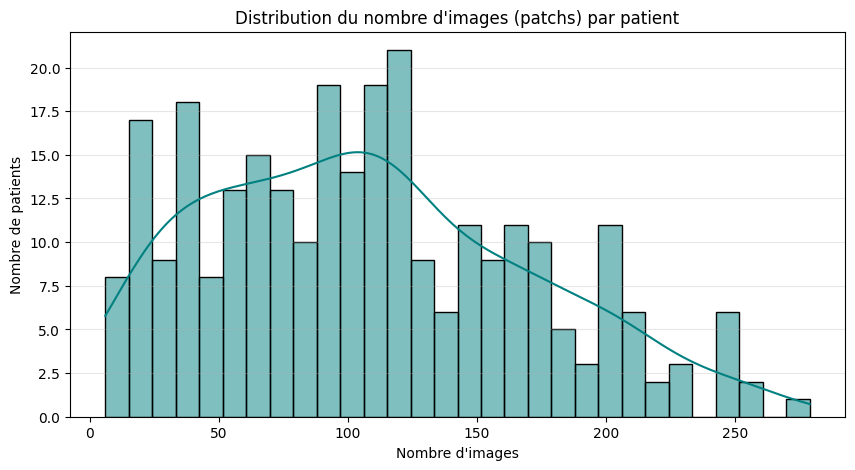

In [ ]:


#  nombre d'images par patient
patches_per_patient = dframe['patient_id'].value_counts()

print(f"\nStatistiques des patchs par patient :")
print(f"Minimum de patchs/patient : {patches_per_patient.min()}")
print(f"Maximum de patchs/patient : {patches_per_patient.max()}")
print(f"Moyenne de patchs/patient : {patches_per_patient.mean():.2f}")


plt.figure(figsize=(10, 5))
sns.histplot(patches_per_patient.values, bins=30, kde=True, color='teal')
plt.title('Distribution du nombre d\'images (patchs) par patient')
plt.xlabel('Nombre d\'images')
plt.ylabel('Nombre de patients')
plt.grid(axis='y', alpha=0.3)
plt.show()




In [ ]:

print(f"\n--- Vérification du Split par Patient ---")
p_train = set(train_df['patient_id'].unique())
p_val = set(val_df['patient_id'].unique())
p_test = set(test_df['patient_id'].unique())

print(f"Patients dans Train : {len(p_train)}")
print(f"Patients dans Val   : {len(p_val)}")
print(f"Patients dans Test  : {len(p_test)}")

# Intersection (doit être vide)
intersect = p_train.intersection(p_test)
print(f"Fuite de données (Train inter Test) : {len(intersect)} patient(s) en commun (Doit être 0)")


--- Vérification du Split par Patient ---
Patients dans Train : 195
Patients dans Val   : 42
Patients dans Test  : 42
Fuite de données (Train inter Test) : 0 patient(s) en commun (Doit être 0)


##2.2 Distribution des classes (AVANT équilibrage)

## Description du jeu de données



Le jeu de données utilisé dans ce projet est constitué de patchs d'images histopathologiques de tissu mammaire, colorées à l'hématoxyline-éosine (H&E). Chaque patch est de taille  100$\times$100 pixels et est annoté selon deux classes :


*   **non-IDC= 0**  : absence de lésion IDC.
*   **IDC = 1** : présence de carcinome canalaire infiltrant,

Après chargement des images dans le notebook, nous disposons de
$10000$ patchs au total, avec une répartition des classes indiquée de la façon suivante:


*   **Nombre de patchs non-IDC** (classe 0): $7136$
*   **Nombre de patchs IDC** (classe 1): $2864$

Cette répartition permet de vérifier l'éventuel déséquilibre des classes, aspect important pour l'interprétation des métriques de performance. On observe que la classe $0$ représente environ 71% des patchs tandis que la classe 1 n'en représente que 28 %. Ce déséquilibre, bien que modéré, reste suffisant pour biaiser l'apprentissage d'un modèle profond, notamment en histopathologie où la détection correcte de la classe 1 (lésion/cancer) est cruciale.

Sans traitement du déséquilibre, le modèle a tendance à prédire majoritairement la classe majoritaire, ce qui conduit à une accuracy trompeusement élevée mais à une mauvaise performance sur les cas positifs.

Pour corriger le déséquilibre des classes, nous avons adopté une stratégie de **sous-échantillonnage (Undersampling)**. En rééquilibrant artificiellement le Train set (50/50), nous forçons le modèle à apprendre les caractéristiques des deux classes de manière équitable. Il est crucial de noter que nous n'avons pas touché à la distribution du Validation Set ni du Test Set. L'évaluation finale doit se faire sur la distribution réelle (déséquilibrée) pour refléter la performance en conditions réelles






In [ ]:
# distribution des classes dans le deta set complet
print("Distribution DES CLASSES DANS LE DATA SET COMPLET")
count_sain = dframe[dframe['target'] == 0].shape[0]
count_cancer = dframe[dframe['target'] == 1].shape[0]
total = count_sain + count_cancer
ratio_cancer = (count_cancer / total) * 100


Distribution DES CLASSES DANS LE DATA SET COMPLET


=== Distribution AVANT équilibrage (Train Set) ===
Classe 0 (Sain / IDC-)   : 15086 images
Classe 1 (Cancer / IDC+) : 5684 images
Total                    : 20770 images
Ratio de cancer          : 27.37%


/tmp/ipython-input-2594553916.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=train_df, palette=['skyblue', 'salmon'])


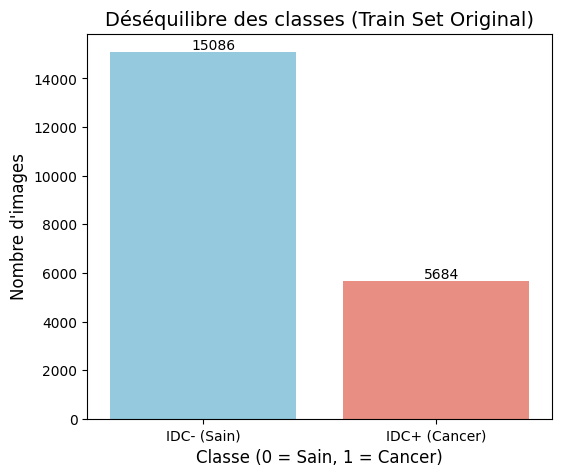

In [ ]:

count_sain = train_df[train_df['target'] == 0].shape[0]
count_cancer = train_df[train_df['target'] == 1].shape[0]
total = count_sain + count_cancer
ratio_cancer = (count_cancer / total) * 100

print(f"=== Distribution AVANT équilibrage (Train Set) ===")
print(f"Classe 0 (Sain / IDC-)   : {count_sain} images")
print(f"Classe 1 (Cancer / IDC+) : {count_cancer} images")
print(f"Total                    : {total} images")
print(f"Ratio de cancer          : {ratio_cancer:.2f}%")


plt.figure(figsize=(6, 5))
ax = sns.countplot(x='target', data=train_df, palette=['skyblue', 'salmon'])

plt.title('Déséquilibre des classes (Train Set Original)', fontsize=14)
plt.xlabel('Classe (0 = Sain, 1 = Cancer)', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks([0, 1], ['IDC- (Sain)', 'IDC+ (Cancer)'])

# pour ajouter des nbr sur les barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.35, p.get_height() + 100))

plt.show()

#3. Dataset, Transformations et DataLoaders

Pour exploiter l'infrastructure PyTorch, nous définissons une classe personnalisée `BreastCancerDataset` qui hérite de `torch.utils.data.Dataset`. Cette classe renferme :

*   Les chemins d'accès aux fichiers et labels stockées dans un DataFrame pandas ;
* Les transformations à appliquer (augmentation, redimensionnement, normalisation).
La méthode `__getitem__` charge l'image à la volée depuis le disque, lui applique les transformations, et retourne un couple (tenseur image, label) pour un indice donné.

Contrairement à une photo de paysage (où le ciel est toujours en haut), une image de biopsie est invariante par rotation. Une tumeur reste une tumeur, qu'elle soit orientée au nord ou au sud. **L'augmentation** permet d'encoder cette invariance dans le modèle et de réduire le sur-apprentissage (overfitting) en créant artificiellement de nouveaux exemples. En revanche, pour la validation et le test, seules la conversion en tenseur et la normalisation sont appliquées, afin d'évaluer le modèle dans des conditions plus proches des données d'origine.

Au niveau des DataLoaders, nous utilisons :

*   Un DataLoader d'entraînement avec shuffle=True pour présenter les données dans un ordre aléatoire à chaque époque et casser les corrélations temporelles ;
*   Des DataLoaders de validation et de test avec `shuffle=False` pour une évaluation déterministe et reproductible.

Les DataLoaders gèrent automatiquement la création de mini-batches et le chargement parallèle (via num_workers), ce qui permet une exploitation efficace du GPU et une stabilisation de la descente de gradient

In [ ]:
class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        label = row['target']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalisation par les moyennes et écarts-types de ImageNet
])

val_test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# pour l'equilibrage du Train on fait de l'Undersampling  en prenant autant de négatifs que de positifs
df_train_pos = train_df[train_df['target'] == 1]
df_train_neg = train_df[train_df['target'] == 0]


df_train_neg_sampled = df_train_neg.sample(n=len(df_train_pos), random_state=42)
train_df_balanced = pd.concat([df_train_pos, df_train_neg_sampled])

print(f"Train équilibré : {len(train_df_balanced)} images (50/50)")

Train équilibré : 11368 images (50/50)


In [ ]:

batch_size = 64

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(42)


train_dataset_balanced = BreastCancerDataset(train_df_balanced, transform=train_transform)
train_loader = DataLoader(train_dataset_balanced, batch_size=batch_size, shuffle=True, num_workers=2,worker_init_fn=seed_worker,
    generator=g)


train_eval_dataset = BreastCancerDataset(train_df, transform=val_test_transform)
train_eval_loader = DataLoader(train_eval_dataset, batch_size=batch_size, shuffle=False, num_workers=2,worker_init_fn=seed_worker,
    generator=g)


val_dataset = BreastCancerDataset(val_df, transform=val_test_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2,worker_init_fn=seed_worker,
    generator=g)

test_dataset = BreastCancerDataset(test_df, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2,worker_init_fn=seed_worker,
    generator=g)

##3.1 Distribution des classes dans le Train_set APRÈS équilibrage

--- Distribution APRÈS équilibrage (Train Set) ---
Classe 0 (Sain / IDC-)   : 5684 images
Classe 1 (Cancer / IDC+) : 5684 images
Total                    : 11368 images
Ratio                    : 50% / 50%


/tmp/ipython-input-841213443.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=train_df_balanced, palette=['skyblue', 'salmon'])


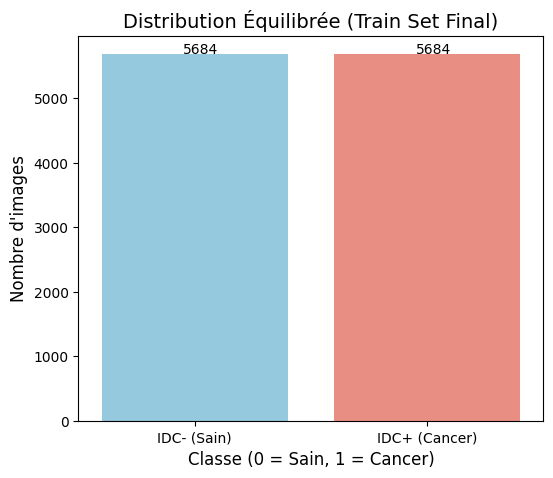

In [ ]:
#  Calcul des nombres exacts sur le dataset équilibré
count_sain_bal = train_df_balanced[train_df_balanced['target'] == 0].shape[0]
count_cancer_bal = train_df_balanced[train_df_balanced['target'] == 1].shape[0]
total_bal = count_sain_bal + count_cancer_bal

print(f"--- Distribution APRÈS équilibrage (Train Set) ---")
print(f"Classe 0 (Sain / IDC-)   : {count_sain_bal} images")
print(f"Classe 1 (Cancer / IDC+) : {count_cancer_bal} images")
print(f"Total                    : {total_bal} images")
print(f"Ratio                    : 50% / 50%")


plt.figure(figsize=(6, 5))
ax = sns.countplot(x='target', data=train_df_balanced, palette=['skyblue', 'salmon'])

plt.title("Distribution Équilibrée (Train Set Final)", fontsize=14)
plt.xlabel("Classe (0 = Sain, 1 = Cancer)", fontsize=12)
plt.ylabel("Nombre d\'images", fontsize=12)
plt.xticks([0, 1], ["IDC- (Sain)", "IDC+ (Cancer)"])


for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + 0.35, p.get_height() + 5))

plt.show()

##3.2 Affichage de quelques images de chaque classe


---




Une exploration simple de la distribution des labels et un affichage de quelques patchs IDC et non-IDC permettent de se familiariser avec les données. On observe notamment des variations importantes en termes de densité cellulaire, de morphologie nucléaire et de texture tissulaire, ce qui laisse penser qu'un réseau de neurones convolutionnel devrait être particulièrement adapté à cette tâche.





In [ ]:

def show_sample_images(df, n_samples=10):
    df_sain = df[df['target'] == 0]
    df_cancer = df[df['target'] == 1]

    samples_sain = df_sain.sample(n=n_samples, random_state=42)
    samples_cancer = df_cancer.sample(n=n_samples, random_state=42)
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

    # rangée 1: Tissus Sains
    for i, (_, row) in enumerate(samples_sain.iterrows()):
        img_path = row['path']
        img = Image.open(img_path)

        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Sain (IDC-)\nPat: {row['patient_id']}")
        axes[0, i].axis('off')

    #  rangée 2: Tissus Cancéreux
    for i, (_, row) in enumerate(samples_cancer.iterrows()):
        img_path = row['path']
        img = Image.open(img_path)

        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Cancer (IDC+)\nPat: {row['patient_id']}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


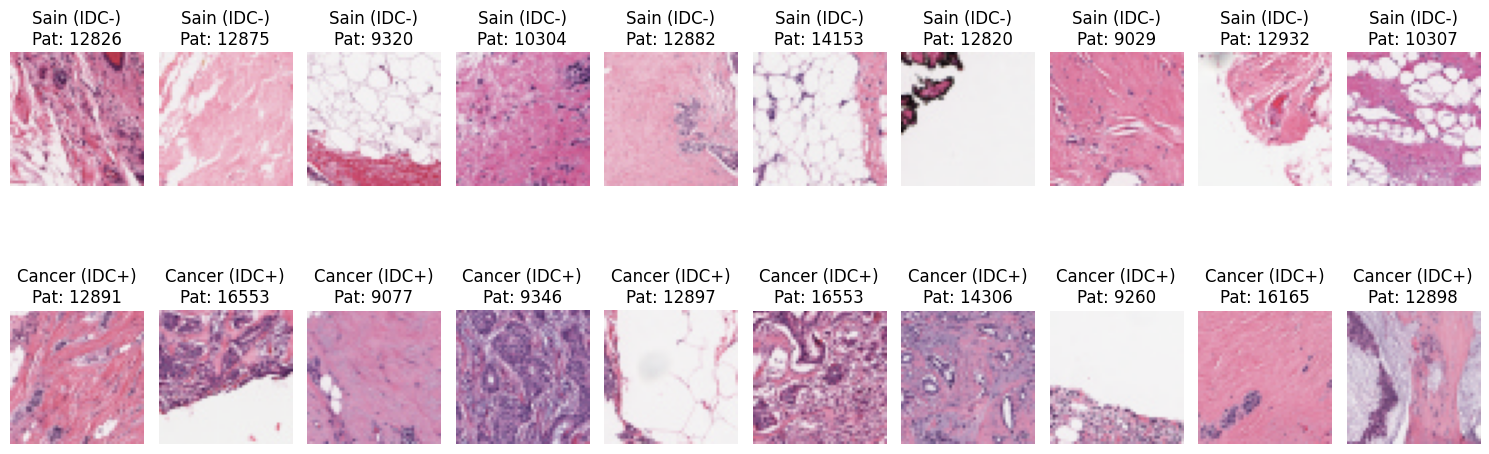

In [ ]:
show_sample_images(train_df, n_samples=10)

### Caractéristiques du Cancer (IDC+) :
On observe généralement une densité cellulaire plus élevée (plus de points violets), des noyaux de formes irrégulières et une désorganisation de la structure du tissu


---
###Caractéristiques du Tissu Sain (IDC-) :
Le tissu sain présente souvent une structure plus organisée, moins dense, avec plus d'espace rose entre les noyaux. Cependant, on remarque que certaines images saines peuvent être denses et ressembler à des images cancéreuses (et inversement). Cela confirme que la classification n'est pas triviale et nécessite un modèle capable de capter des motifs de texture fins d'où l'utilisation de CNN.





In [ ]:
# ici on a besoin de beucoup de batchs par patient pour visualiser correctement les tumeurs
records = []
for filepath in data:
    filename = os.path.basename(filepath)
    pid = filename.split('_')[0]
    parts = filename.split('_')
    x = int([p for p in parts if p.startswith('x')][0][1:])
    y = int([p for p in parts if p.startswith('y')][0][1:])
    if 'class1' in filename:
        target = 1
    elif 'class0' in filename:
            target = 0
    records.append({'path': filepath,'patient_id': pid,'target': target,'x': x,'y': y})

df = pd.DataFrame(records)
print(f"DataFrame prêt : {len(df)} lignes (images).")
print(f"Nombre de patients uniques : {df['patient_id'].nunique()}")
print(df.head())


DataFrame prêt : 555048 lignes (images).
Nombre de patients uniques : 279
                                                path patient_id  target     x  \
0  /kaggle/input/breast-histopathology-images/IDC...       9073       0  2851   
1  /kaggle/input/breast-histopathology-images/IDC...      10268       0  2751   
2  /kaggle/input/breast-histopathology-images/IDC...      16568       0   701   
3  /kaggle/input/breast-histopathology-images/103...      10304       1   351   
4  /kaggle/input/breast-histopathology-images/IDC...      12934       0  3151   

      y  
0  1251  
1  1851  
2   901  
3   701  
4  2401  


le code suivant a pour but de reconstruire visuellement la forme du tissu mammaire de 9 patients différents.

Comme le dataset est composé de patchs découpés dans une grande image de microscope, on utilise les coordonnées x et y présentes dans le nom de chaque fichier pour replacer ces carrés au bon endroit sur un graphique

In [ ]:
df = pd.DataFrame(records)
print("Extraction des coordonnées X et Y pour toutes les images...")

def get_coords(filepath): # pour extraire les coordonnées
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    x_part = [p for p in parts if p.startswith('x')][0]
    y_part = [p for p in parts if p.startswith('y')][0]
    x = int(x_part[1:])
    y = int(y_part[1:])
    return x, y
coords = df['path'].apply(get_coords)
df['x'] = [c[0] for c in coords]
df['y'] = [c[1] for c in coords]








Extraction des coordonnées X et Y pour toutes les images...


Affichage de la reconstruction pour les patients : ['8974' '13591' '9125' '14190' '12811' '16533' '12810' '9083' '13023']


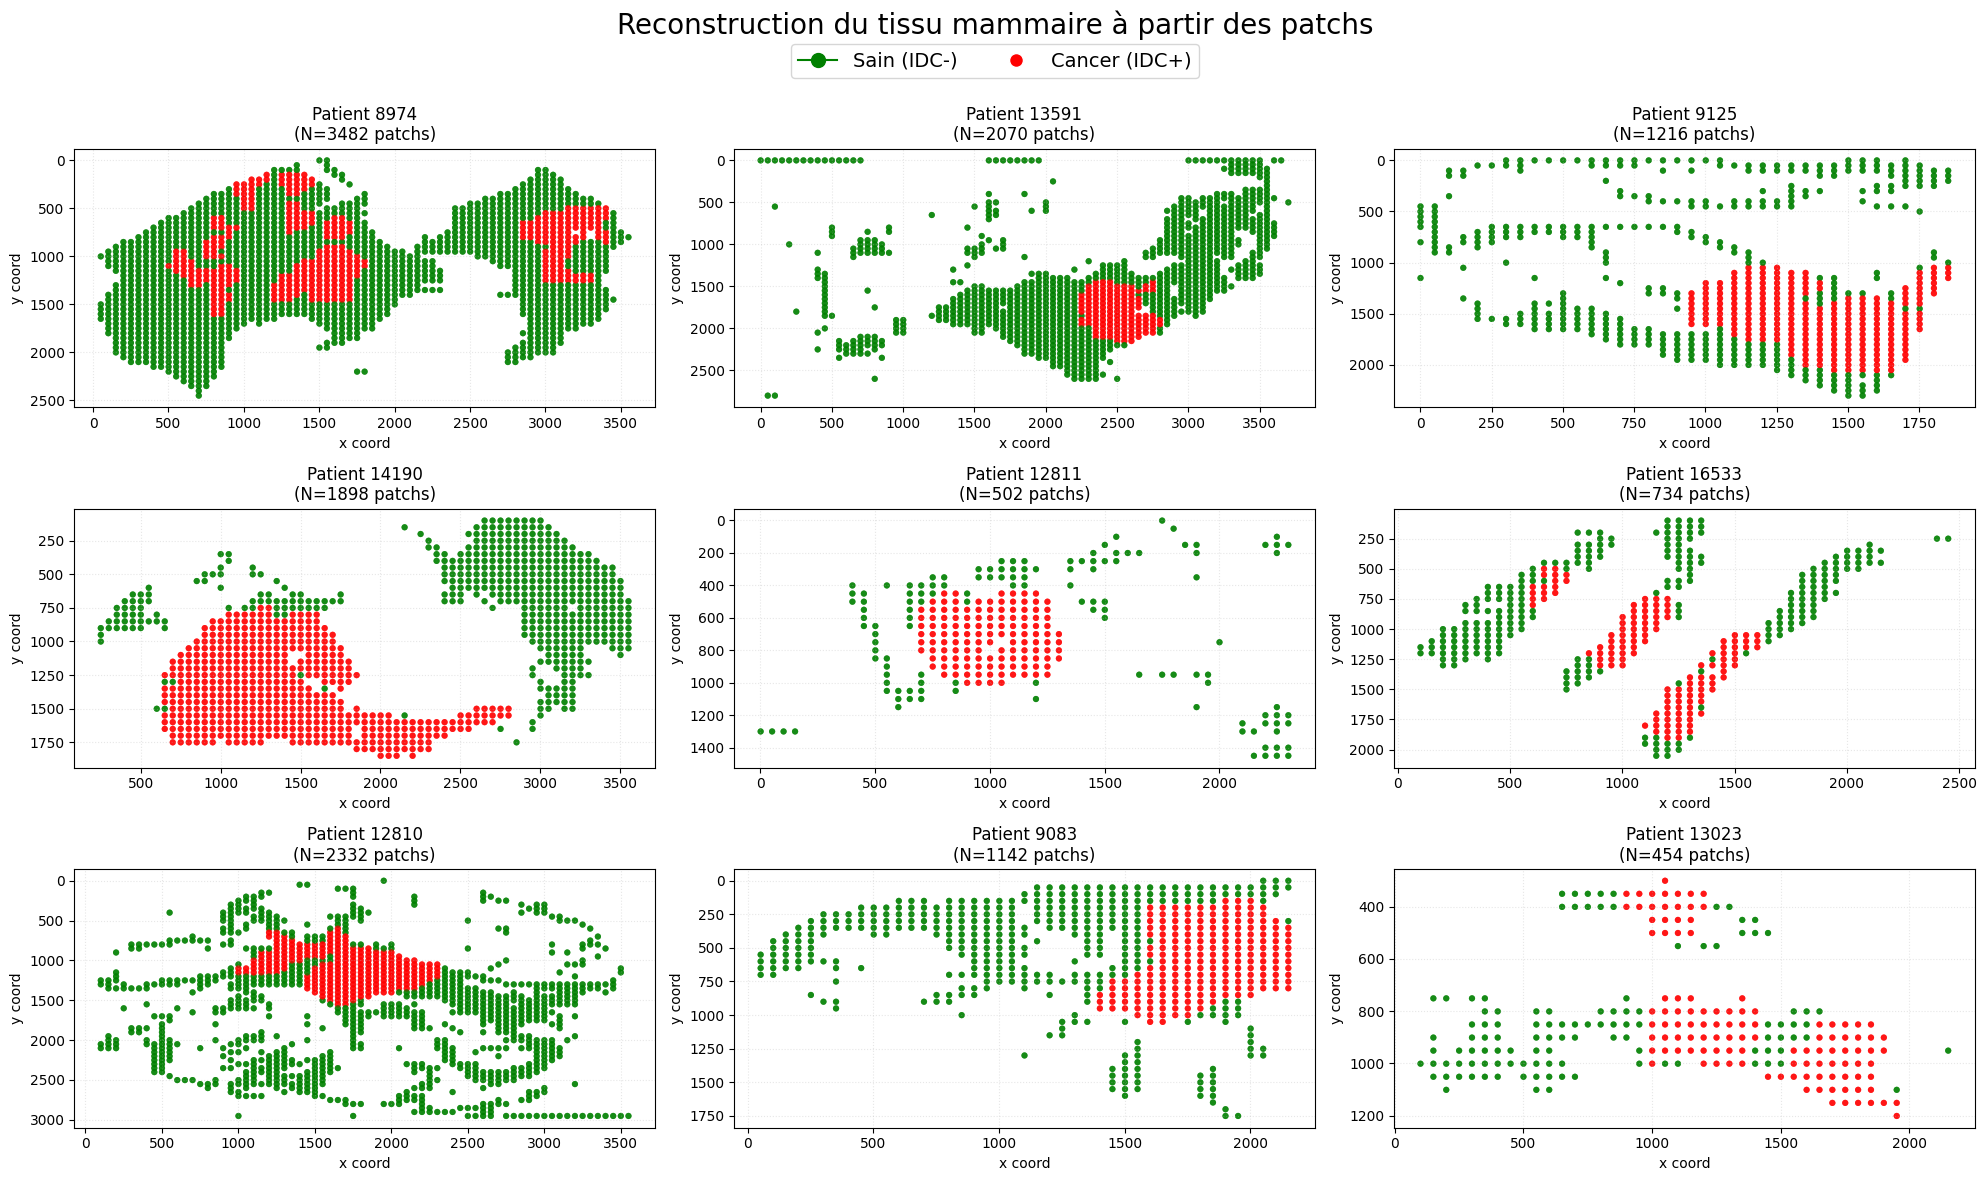

In [ ]:
def get_patient_df(patient_id):
    return df[df['patient_id'] == str(patient_id)].copy()

n_rows = 3
n_cols = 3
n_imgs = n_rows * n_cols


colors = ['green', 'red']
cmap = ListedColormap(colors)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 12))
valid_patients = df['patient_id'].value_counts()
valid_patients = valid_patients[valid_patients > 50].index.tolist()
np.random.seed(42)
patient_ids = np.random.choice(valid_patients, size=n_imgs, replace=False)

print(f"Affichage de la reconstruction pour les patients : {patient_ids}")

for row in range(n_rows):
    for col in range(n_cols):
        idx = col + n_cols * row
        patient_id = patient_ids[idx]
        patient_df = get_patient_df(patient_id)

        ax[row, col].scatter(
            patient_df.x.values,
            patient_df.y.values,
            c=patient_df.target.values,
            cmap=cmap,
            s=20,   #  ici si je veux changer la taille des points
            alpha=0.7,  # transparence pour voir la densité
            edgecolors='none'
        )

        # POINT IMPORTANT ICI : en imagerie, l'origine (0,0) est en haut à gauche d'aprés les batchs au début.
        # Mais un scatter plot a l'origine en bas à gauche.
        # donc il faut inverser l'axe Y pour retrouver la forme réelle du tissu.
        ax[row, col].invert_yaxis()
        ax[row, col].set_title(f"Patient {patient_id}\n(N={len(patient_df)} patchs)", fontsize=12)
        ax[row, col].set_xlabel("x coord")
        ax[row, col].set_ylabel("y coord")
        ax[row, col].grid(True, linestyle=':', alpha=0.3)



legend_elements = [
    Line2D([0], [0], marker='o', color='green', markerfacecolor='green', markersize=10, label='Sain (IDC-)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cancer (IDC+)')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 0.96))

plt.suptitle("Reconstruction du tissu mammaire à partir des patchs", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Laisser de la place pour le titre
plt.show()

**Croissance Cellulaire du cancer** : Le cancer ( le carcinome ici) commence généralement par une ou quelques cellules qui mutent. Ces cellules se divisent de manière incontrôlée pour former une tumeur. La tumeur grandit en envahissant l'espace autour d'elle. Elle progresse comme une tache d'huile ou un feu de forêt. C'est pourquoi, si un patch est cancéreux, il y a une très forte probabilité que ses voisins immédiats le soient aussi. C'est une information cruciale que notre modèle (CNN patch par patch) ignore. notre CNN regarde chaque carré isolément, s'il hésite sur un patch flou, il ne sait pas ce qu'il y a autour.

#4. Modèle CNN et Fonction d'Évaluation
---

Avant d'utiliser des architectures complexes comme ResNet, il est de bonne pratique scientifique d'établir une baseline avec un modèle simple. Nous avons implémenté un réseau de neurones convolutionnel (SimpleCNN) suivant une structure classique:


*   Trois blocs convolutionnels successifs (Conv2d + ReLU), chacun suivi d'un MaxPooling pour réduire la dimensionnalité spatiale.
*   Un classificateur (fully-connected) intégrant une couche de Dropout ($0.5$) pour la régularisation, produisant le score final de la classe IDC

L'entraînement est supervisé par la fonction de perte BCEWithLogitsLoss, choisie pour sa stabilité numérique, et l'optimiseur Adam (taux d'apprentissage initial de $1e-3$).
##4.1. Stabilisation et Optimisation :
Pour améliorer la généralisation de l'optimiseur Adam, nous nous sommes initialement appuyés sur les travaux de Gupta et al. ("Adam vs. SGD") en tentant d'implémenter la Normalisation des Poids (Weight Normalization ou LAWN). L'objectif était de contraindre l'espace de recherche pour éviter les minima locaux sous-optimaux.

Cependant, cette approche a engendré des instabilités numériques persistantes (explosion du gradient et valeurs NaN), dues à la sensibilité de la méthode à l'initialisation. Face à ce constat, nous avons pivoté vers la Batch Normalization (BN). Cette technique standard normalise les activations (et non les poids) couche par couche. Elle nous a permis de bénéficier des mêmes avantages théoriques que LAWN (convergence accélérée, meilleure généralisation) tout en garantissant une stabilité numérique parfaite, menant le modèle à une AUC de validation d'environ $0.90$.

**Référence:**  A. Gupta, R. Ramanath, J. Shi & S.S. Keerthi.,"Adam vs. SGD: Closing the generalization gap on image classification",13th Annual Workshop on Optimization for Machine Learning.
https://www.opt-ml.org/papers/2021/paper53.pdf



##4.2 Méthodes d'Entraînement

Les deux modèles (SimpleCNN et ResNet18) sont entraînés pendant un nombre fixe d'époques en utilisant l'ensemble d'entraînement et en surveillant les performances sur l'ensemble de validation après chaque époque. Nous faisons le choix de `BCEWithLogitsLoss` sans pondération comme fonction de coût puisque nous avons équilibré le dataset d'entraînement (50/50) via le sous-échantillonnage, la pondération de la loss devient inutile, voire contre-productive. La BCE (Binary Cross Entropy) est la loss standard mathématiquement adaptée à la classification binaire

Nous utilisons plusieurs métriques de performance :

*   accuracy (taux de bonne classification),
*   La matrice de confusion
*   **ROC**(Receiver Operating Characteristic) et sa métrique associée **AUC**(Area Under the Curve), qui mesure la capacité du modèle à séparer les deux classes indépendamment d'un seuil de décision spécifique.

La courbe ROC est un graphique qui permet d'évaluer la qualité d'un modèle de classification et permet d'observer deux mesures importantes, la **sensibilité** qui est la capacité à détecter correctement les **vrais positifs** et la **spécificité** qui donne le taux de faux positifs.

L'**AUC** est simplement l'aire sous la courbe **ROC**, elle permet de résumer la performance du modèle en un nombre entre **0** et **1**:

*   $AUC=1$ modèle parfait,
*   $AUC=0.5$ modèle aussi bon que du hasard,
*   $AUC>0.8$ modèle généralement très bon

L'intérêt principal est que l'AUC ne dépend pas du déséquilibre entre les classes (cas positifs/ négatifs). C'est très utile dans les domaines où les cas positifs sont rares, comme le diagnostic médical ou la détection de fraude comme dans notre cas ici avec la carcinome, c'est une métrique beaucoup plus robuste pour évaluer la qualité diagnostique globale que l'Accuracy qui peut être trompeuse sur des données médicales. Afin d'éviter le sur-apprentissage, nous avons mis en place un mécanisme d'**early stopping** basé sur l'AUC de validation, après chaque époque l'AUC est calculée sur l'ensemble de validation , si aucune amélioration n'est observée pendant 'patience' époques consécutives, l'entraînement est interrompu et les poids correspondant à la **meilleure AUC** observée sont restaurés. Nous avons également utilisé un `scheduler ReduceLROnPlateau` pour réduire automatiquement le taux d'apprentissage lorsque la perte de validation stagnait, ce qui aide souvent à franchir des plateaux d'optimisation.

Nous suivons également une courbe TrainEval (Train set sans augmentation) en parallèle de la ValLoss, en effet, comparer la Loss d'entraînement (calculée avec Dropout et Augmentation) à la Loss de validation (calculée sur images propres) revient à comparer des pommes et des oranges. Pour détecter un vrai sur-apprentissage (overfitting), nous ajoutons une évaluation sur le Train Set 'propre' à chaque époque.


NOTE / LA REFERENCE: https://datascientest.com/courbe-roc-auc-tout-savoir

##4.3 CNN

In [ ]:
class SimpleCNN_BN(nn.Module):
    def __init__(self):
        super(SimpleCNN_BN, self).__init__()

        self.features = nn.Sequential(
            # Bloc 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 100 à 50

            # Bloc 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),# 50 à 25

            # Bloc 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),# 25 à 12
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1)

##4.4 La Boucle d'Entraînement

In [ ]:
def evaluation(model, data_loader, criterion, device):
    model.eval()
    all_logits = []
    all_labels= []
    running_loss = 0.0
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float()

            logits = model(imgs)
            if logits.dim() > 1: logits = logits.view(-1)

            loss = criterion(logits, labels)
            running_loss += loss.item() * imgs.size(0)

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    avg_loss = running_loss / len(data_loader.dataset)

    # Métriques
    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()
    probs = 1 / (1 + np.exp(-all_logits))
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(all_labels, preds)
    f1  = f1_score(all_labels, preds)
    try:
        auc = roc_auc_score(all_labels, probs)
    except ValueError:
        auc = np.nan

    return avg_loss, acc, f1, auc

In [ ]:

model = SimpleCNN_BN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
num_epochs = 50
patience = 5
best_val_auc = 0.0
best_state = None
epochs_no_improve = 0
history = {
    "train_loss": [],      # Loss sur le batch (avec augmentation)
    "train_eval_loss": [], # Loss sur tout le train
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "val_auc": []
}

print("Lancement de l'entraînement complet...")

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    # Backprop
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        logits = model(imgs)
        if logits.dim() > 1: logits = logits.view(-1)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc, val_f1, val_auc = evaluation(model, val_loader, criterion, device)
    train_eval_loss, train_acc, _, _ = evaluation(model, train_eval_loader, criterion, device)


    history["train_loss"].append(train_loss)
    history["train_eval_loss"].append(train_eval_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_auc"].append(val_auc)
    print(f"Epoch [{epoch}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")
    scheduler.step(val_loss)
    # early stp
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early Stopping donne: Best AUC: {best_val_auc:.4f}")
        break

 #le meilleur model
if best_state:
    model.load_state_dict(best_state)
    print("Meilleur modèle restauré.")

Lancement de l'entraînement complet...
Epoch [1/50] Train Loss: 0.5976 | Train Acc: 0.7682 | Val Loss: 0.5087 | Val Acc: 0.7994 | Val AUC: 0.8829
Epoch [2/50] Train Loss: 0.5021 | Train Acc: 0.7804 | Val Loss: 0.4656 | Val Acc: 0.8133 | Val AUC: 0.8999
Epoch [3/50] Train Loss: 0.4703 | Train Acc: 0.7918 | Val Loss: 0.4409 | Val Acc: 0.8247 | Val AUC: 0.9101
Epoch [4/50] Train Loss: 0.4572 | Train Acc: 0.7895 | Val Loss: 0.4367 | Val Acc: 0.8253 | Val AUC: 0.9137
Epoch [5/50] Train Loss: 0.4504 | Train Acc: 0.7986 | Val Loss: 0.4150 | Val Acc: 0.8319 | Val AUC: 0.9156
Epoch [6/50] Train Loss: 0.4462 | Train Acc: 0.7978 | Val Loss: 0.4153 | Val Acc: 0.8315 | Val AUC: 0.9176
Epoch [7/50] Train Loss: 0.4425 | Train Acc: 0.8051 | Val Loss: 0.4003 | Val Acc: 0.8369 | Val AUC: 0.9190
Epoch [8/50] Train Loss: 0.4388 | Train Acc: 0.8034 | Val Loss: 0.4034 | Val Acc: 0.8369 | Val AUC: 0.9202
Epoch [9/50] Train Loss: 0.4370 | Train Acc: 0.8089 | Val Loss: 0.3917 | Val Acc: 0.8403 | Val AUC: 0.921

##4.5 Affichage

In [ ]:


def plot_curves(history, model_name="Modèle"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(21, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Train Loss (Augmenté)', alpha=0.4)
    plt.plot(epochs, history['train_eval_loss'], 'go-', label='Train Loss (Clean)', alpha=0.8)
    plt.plot(epochs, history['val_loss'], 'r*-', label='Val Loss')

    plt.title(f'{model_name} - Loss')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], 'go-', label='Train Accuracy', alpha=0.8)
    plt.plot(epochs, history['val_acc'], 'r*-', label='Val Accuracy')

    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Époques')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right') # Souvent mieux en bas à droite pour l'accuracy
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_auc'], 'purple', linewidth=2, marker='o', label='Validation AUC')

    plt.title(f'{model_name} - AUC Score')
    plt.xlabel('Époques')
    plt.ylabel('AUC')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


In [ ]:
plot_curves(history, model_name="SimpleCNN")

##4.6 Matrice de confusion
La matrice de confusion ou matrice d'erreur est notre outil décisionnel principal lors de la phase de validation. Contrairement à l'exactitude (Accuracy) qui masque la nature des erreurs, la matrice nous permet de quantifier les Faux Négatifs (cancers manqués **FN**) et peut servir à calculer d'autres indicateurs d'évaluation de modèles destinées à mesurer les performances du modèle, à savoir:

*   La précision correspond à la proportion de prédictions de classes positives qui appartiennent réellement à la classe en question, On peut également considérer qu'elle mesure la probabilité qu'une instance choisie au hasard appartienne à une certaine classe.La précision peut également être appelée valeur prédite positive (**PPV**). Elle est représentée par l'équation suivante : $PPV=\frac{TP}{(TP + FP)}$, la précision est une métrique utile dans les cas où le faux positif est une préoccupation plus élevée que les faux neagtifs.
* Le rappel (Sensibilité / Taux Positif Véritable **TPR**) qui est une mesure des observations réelles qui sont prédites correctement, c'est-à-dire combien d'observations de classe positive sont réellement prédites comme positives. Le rappel est important lorsque la minimisation des faux négatifs est plus critique que de minimiser les faux positifs. La sensibilité ou taux de vrais positifs (TPR) est représenté par l'équation suivante :  
$$TPR=\frac{TP}{(TP + FN)}$$.


*   Spécificité (Taux Négatif Véritable **TNR**) qui représente la capacité d'un modèle ou d'un classificateur à identifier avec précision les vrais cas négatifs, c'est à dire dans quelle mesure le modèle peut identifier correctement les cas réellement négatifs parmi tous les cas réellement négatifs. Une spécificité plus élevée indique que le modèle est plus précis dans l'identification des vrais négatifs et qu'il a moins de risques de les identifier à tort comme positifs, ce qui est important pour garantir la précision dans notre application. Elle est représenté par l'équation suivante : $$TNP=\frac{TN}{(TN + FP)}$$

Bien qu'ils soient utiles, ni la précision ni le recall ne permettent d'évaluer entièrement un modèle. Séparément c'est deux métrique sont inutiles :
* Le **F1-score** est la moyenne harmonique de précision et de rappel, et fournit une mesure équilibrée qui combine les deux métriques. C'est un bon choix lorsque la précision et le rappel sont tout aussi importants, et cela aide à trouver un compromis entre précision et rappel et il est souvent utilisé lorsqu'il y a une distribution de classe inégale ou un déséquilibre de classe, et il fournit une valeur unique qui résume les performances du modèle. Le F1 score est représenté par l'équation suivante :
 $$score=2×\frac{recall\times precision}{(recall + precison)}$$

Nous avons utilisé cette analyse sur l'ensemble de validation pour sélectionner le modèle qui minimise le risque clinique (maximisation du Rappel/Sensibilité), avant de l'évaluer définitivement sur l'ensemble de test.

### Le Seuil Optimal (L'Indice de Youden)


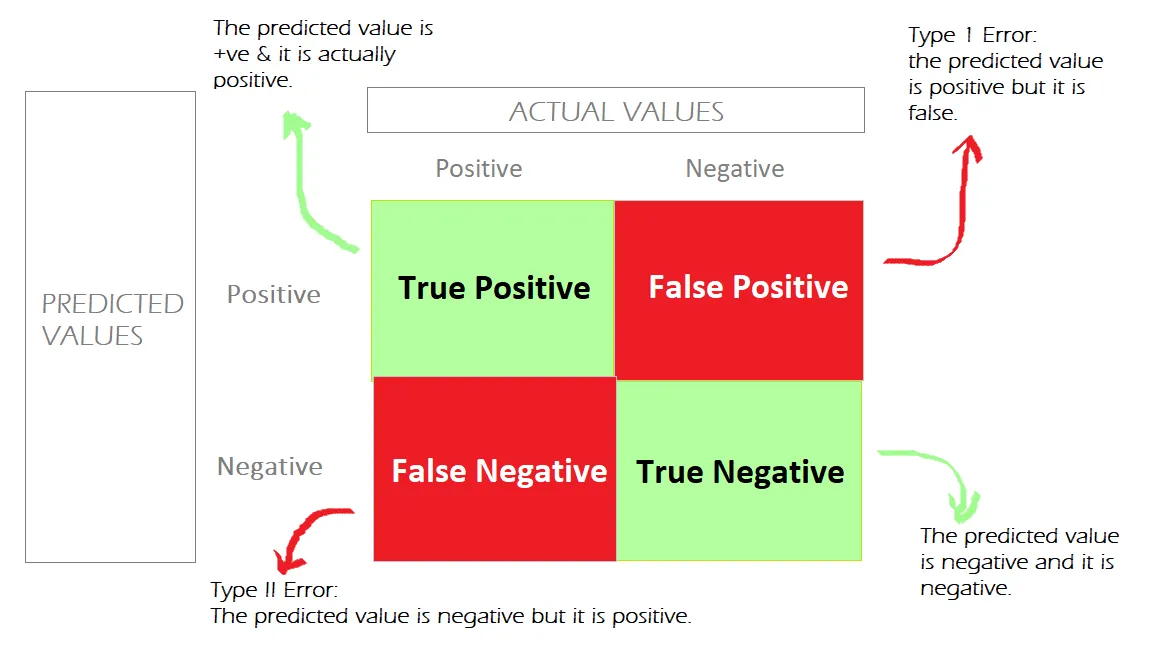

**Références:**
1. https://www.ibm.com/fr-fr/think/topics/confusion-matrix
2. https://medium.com/@nikitamalviya/confusion-matrix-870739a1ec31
3. https://inside-machinelearning.com/recall-precision-f1-score/

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix
def optimize_threshold_and_plot(model, data_loader, device, model_name="Modèle"):
    model.eval()
    all_preds_prob = []
    all_labels = []


    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float()

            logits = model(imgs)
            if logits.dim() > 1: logits = logits.view(-1)
            probs = torch.sigmoid(logits)

            all_preds_prob.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcul du Seuil Optimal (Youden)
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds_prob)
    j_scores = tpr + (1 - fpr) - 1
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]

    print(f" Seuil Optimal trouvé (Youden) : {best_threshold:.4f}")
    new_preds = (np.array(all_preds_prob) >= best_threshold).astype(int)
    cm = confusion_matrix(all_labels, new_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Sain (0)', 'Malade (1)'],
                yticklabels=['Sain (0)', 'Malade (1)'])
    plt.title(f'Matrice Optimisée (Seuil {best_threshold:.2f})')
    plt.xlabel('Prédiction du Modèle')
    plt.ylabel('Vérité Terrain')
    plt.show()
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn) if (tp + fn)    # Sensibilité
    specificity = tn / (tn + fp) if (tn + fp) # Spécificité
    precision = tp / (tp + fp) if (tp + fp)  # Précision
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0

    print(f"--- RÉSULTATS DÉTAILLÉS ({model_name}) ---")
    print(f"Seuil de décision       : {best_threshold:.4f}")
    print(f"-------------------------------------------")
    print(f"Vrais Positifs (TP)     : {tp} (Malades bien détectés)")
    print(f"Faux Négatifs  (FN)     : {fn} (DANGER : Malades ratés)")
    print(f"Faux Positifs  (FP)     : {fp} (Fausses alertes)")
    print(f"Vrais Négatifs (TN)     : {tn} (Sains bien classés)")
    print(f"-------------------------------------------")
    print(f"Sensibilité (Recall)    : {recall:.4f}  (Objectif médical : Maximiser ça)")
    print(f"spécificité             : { specificity:.4f}  (Capacité à ne pas alarmer les sains)")
    print(f"Précision (Precision)   : {precision:.4f}  (Fiabilité de l'alerte)")
    print(f"F1-Score                : {f1:.4f}  (Moyenne harmonique)")




In [ ]:
optimize_threshold_and_plot(model, val_loader, device, model_name="CNN")

##4.7 Test final

In [ ]:
test_loss, test_acc, test_f1, test_auc = evaluation(model, test_loader, criterion, device)
# ERREUR de généralisation (classification error)
error = 1 -test_acc
print(f"\nRÉSULTATS TEST ->Loss: {test_loss}| AUC: {test_auc:.4f} | F1: {test_f1:.4f} | Acc: {test_acc:.4f}")
print(f"Erreur de généralisation:{error}")



RÉSULTATS TEST ->Loss: 0.45811301670828247| AUC: 0.8919 | F1: 0.7369 | Acc: 0.8074
Erreur de généralisation:0.19263397475687982


#5.Transfert de Connaissances avec ResNet18

 Afin de maximiser les performances de classification, nous avons adopté une stratégie de Transfert d'Apprentissage (Transfer Learning) basée sur l'architecture ResNet18, pré-entraînée sur la base de données ImageNet.

Notre approche spécifique est le Fine-Tuning complet. Contrairement à une simple extraction de caractéristiques (où le réseau serait figé), nous avons autorisé la mise à jour de l'ensemble des poids du réseau. Cela permet d'adapter finement les filtres profonds  initialement conçus pour des objets macroscopiques  aux textures histologiques spécifiques du cancer du sein.

Le pipeline est le suivant :

*   **Initialisation:** Chargement du modèle avec ses poids pré-appris.
*   **Adaptation:** Remplacement de la dernière couche fully-connected (1000 classes) par une neurone unique pour la classification binaire (IDC+ vs IDC-).
* **Ré-entraînement :** Optimisation de tous les paramètres avec un taux d'apprentissage réduit pour ne pas détruire les connaissances antérieures.

##5.1. Justification de l'Architecture
Le ResNet18 (Residual Network) est une architecture de référence. Sa principale innovation réside dans l'introduction de blocs résiduels utilisant des connexions "skip" (skip connections).

Ces connexions facilitent la propagation du signal lors de la rétropropagation, résolvant le problème de disparition du gradient (vanishing gradient) fréquent dans les réseaux profonds. Avec ses 18 couches et environ 11 millions de paramètres, ResNet18 offre un compromis idéal pour notre projet : il est assez profond pour capter des abstractions fines, mais suffisamment léger pour éviter le sur-apprentissage (overfitting) sur un jeu de données de taille moyenne, contrairement à des modèles massifs comme ResNet50.

##5.2. Limites et Optimisation
Une limite méthodologique de notre approche réside dans la résolution d'entrée. Nos patchs natifs (50$\times$50) redimensionnés à 100$\times$100 sous-exploitent potentiellement le ResNet, calibré pour du 224$\times$224.

Pour pallier cela et viser une convergence optimale, nous avons modifié notre stratégie d'optimisation. Contrairement au SimpleCNN entraîné avec Adam, nous avons opté pour SGD avec Momentum (0.9) pour le ResNet. Bien que SGD nécessite un réglage plus fin, la littérature (notamment Gupta et al.) suggère qu'il atteint de meilleurs optima globaux sur des réseaux profonds en Computer Vision, là où Adam peut stagner dans des minima locaux. Cette rigueur d'optimisation vise à extraire le maximum de performance de l'architecture résiduelle.



Références:
1. https://blog.roboflow.com/resnet-18/
2. https://www.productteacher.com/quick-product-tips/resnet18-and-resnet50
3. https://fr.mathworks.com/help/deeplearning/ref/resnet18.html#description
4. https://docs.pytorch.org/vision/stable/models.html











##5.3 Stratégies de Sélection et d'Optimisation du Taux d'Apprentissage (LR)
Pour éviter un choix arbitraire du taux d'apprentissage (Learning Rate), nous avons appliqué la méthodologie du LR Range Test décrite par L. N. Smith. En faisant varier exponentiellement le LR sur quelques itérations, nous avons identifié la zone de convergence optimale (pente maximale) avant divergence.

Sur la base de cette analyse, nous avons comparé deux stratégies d'entraînement pour le ResNet18 :


1.   **Stratégie de Décroissance Adaptative** (Baseline ResNet) Dans cette première approche, nous avons fixé le Learning Rate initial à la valeur optimale trouvée (mettre la valeur ici). Cette valeur maximise la vitesse de convergence initiale. Nous l'avons couplée à un scheduler ReduceLROnPlateau, qui réduit le taux lorsqu'un palier de performance est atteint, garantissant une stabilité parfaite pour le  fine-tuning
2. **Stratégie Cyclique "Triangular"** (Conforme à L. N. Smith) Dans une seconde expérimentation, nous avons suivi scrupuleusement la politique Cyclical Learning Rates (CLR) décrite dans l'article. Plutôt que de décroître de manière monotone, nous avons implémenté la méthode "Triangular":

*   **Bornes** : Le LR oscille entre une borne minimale (base-lr) et maximale (max_lr), toutes deux déterminées via le LR Range Test ci dessous, nous avons fixé la borne supérieure (max_lr) au point de gradient minimal (pente la plus raide), garantissant un apprentissage rapide mais stable. La borne inférieure (base_lr) a été fixée à un quart de cette valeur (max_lr / 4), conformément aux recommandations de l'article (`base_lr`=`max_lr`/4) .
* Cette oscillation permet au modèle de traverser périodiquement des zones à fort LR, l'aidant à s'échapper des minima locaux étroits (saddle points) pour converger vers des minima plus larges et plats, favorisant ainsi une meilleure généralisation. La taille du demi-cycle (step_size) a été fixée à 4 époques.





**Référence**: Leslie N. Smith,"Cyclical Learning Rates for Training Neural Networks", U.S. Naval Research Laboratory, Code 5514. https://arxiv.org/abs/1506.01186



In [ ]:

def lr_range_test(model, train_loader, optimizer, criterion, device, start_lr=1e-7, end_lr=10, num_iter=1000):
    model.train()
    lrs = []
    losses = []
    best_loss = float('inf')

    lr_lambda = lambda x: (end_lr / start_lr) ** (x / num_iter)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    for param_group in optimizer.param_groups:
        param_group['lr'] = start_lr

    iter_count = 0
    while iter_count < num_iter:
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            logits = model(imgs).view(-1)
            loss = criterion(logits, labels)

            if not np.isnan(loss.item()):
                if iter_count > 10 and loss.item() > 4 * best_loss:
                    print(f"Explosion de la Loss à l'itération {iter_count}. Arrêt.")
                    iter_count = num_iter
                    break
                if loss.item() < best_loss:
                    best_loss = loss.item()
            else:
                print("NaN détecté.")
                iter_count = num_iter
                break
            loss.backward()
            optimizer.step()
            scheduler.step()

            lrs.append(optimizer.param_groups[0]['lr'])
            losses.append(loss.item())

            iter_count += 1
            if iter_count >= num_iter:
                break
    def smooth(scalars, weight=0.90):
        last = scalars[0]
        smoothed = list()
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return np.array(smoothed)

    if len(losses) == 0:
        return start_lr

    smoothed_losses = smooth(losses)


    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses, label='Loss brute', alpha=0.2)
    plt.plot(lrs, smoothed_losses, label='Loss lissée', color='blue')
    plt.scatter(suggested_lr, smoothed_losses[lrs.index(suggested_lr)], color='red', s=70, label=f'LR: {suggested_lr:.1e}', zorder=5)

    plt.xscale('log')
    plt.xlabel("Learning Rate (Log Scale)")
    plt.ylabel("Loss")
    plt.title(f"LR Finder ({num_iter} itérations)")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

    return suggested_lr





Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Explosion de la Loss à l'itération 129. Arrêt.
 LR suggéré (Pente max) : 2.54e-03


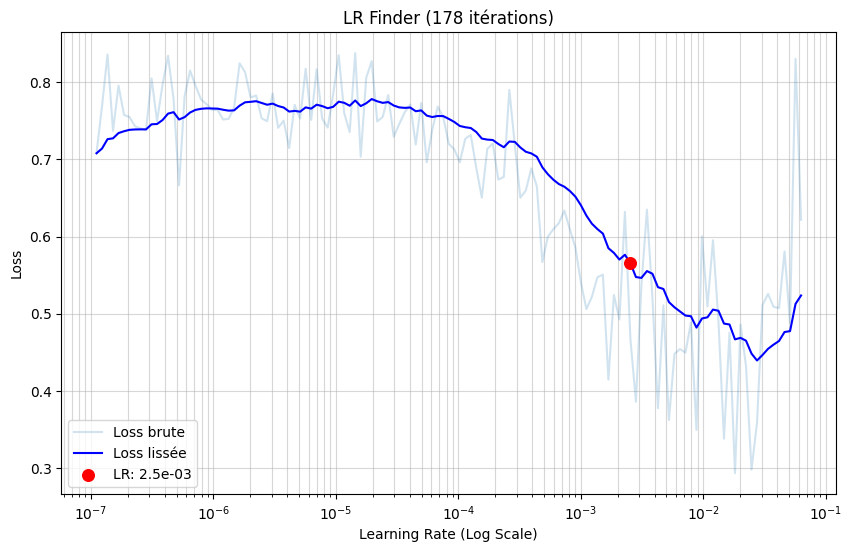

In [ ]:
resnet = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)
resnet = resnet.to(device)
temp_optimizer = optim.SGD(resnet.parameters(), lr=1e-7, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
# On scanne sur exactement 1 époque
iters_optimal = len(train_loader)
max_lr = lr_range_test(resnet, train_loader, temp_optimizer, criterion, device, num_iter=iters_optimal)

In [ ]:

resnet = models.resnet18(weights='IMAGENET1K_V1')

# Fine-tuning complet avec true
for param in resnet.parameters():
    param.requires_grad = True

# on remplace la dernière couche
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)
resnet = resnet.to(device)

criterion = nn.BCEWithLogitsLoss()
#optimizer_resnet = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-4)
#scheduler_resnet = optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet, mode='min', factor=0.5, patience=2)
# methode 3: SGD avec molentum 0.9 + cyclicLR
'''
step_size_up = 4 * len(train_loader)

scheduler_resnet = optim.lr_scheduler.CyclicLR(
    optimizer_resnet,
    base_lr=max_lr / 4,
    max_lr=max_lr,
    step_size_up=step_size_up,
    mode='triangular',
    cycle_momentum=True
)
'''
patience = 5
best_val_auc_resnet = 0.0
best_state_resnet = None
epochs_no_improve = 0
num_epochs_resnet = 50

history_resnet = {
    "train_loss": [], "train_eval_loss": [],
    "train_acc": [], "val_loss": [],
    "val_acc": [], "val_auc": []
}
for epoch in range(1, num_epochs_resnet + 1):
    resnet.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).float()

        optimizer_resnet.zero_grad()
        logits = resnet(imgs).view(-1)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet.parameters(), max_norm=1.0)
        optimizer_resnet.step()
        # Pour CyclicLR on step par batch
        #scheduler_resnet.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    val_loss, val_acc, val_f1, val_auc = evaluation(resnet, val_loader, criterion, device)
    train_eval_loss, train_acc, _, _ = evaluation(resnet, train_eval_loader, criterion, device)
    history_resnet['train_loss'].append(train_loss)
    history_resnet['train_eval_loss'].append(train_eval_loss)
    history_resnet['train_acc'].append(train_acc)
    history_resnet['val_loss'].append(val_loss)
    history_resnet['val_acc'].append(val_acc)
    history_resnet['val_auc'].append(val_auc)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")
    # early Stop
    if val_auc > best_val_auc_resnet:
        best_val_auc_resnet = val_auc
        best_state_resnet = copy.deepcopy(resnet.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping ! Best AUC: {best_val_auc_resnet:.4f}")
        break

if best_state_resnet is not None:
    resnet.load_state_dict(best_state_resnet)
    print("Meilleur modèle ResNet restauré.")

Préparation du ResNet18...
Epoch 1 | Train Loss: 0.3975 | Train Acc: 0.8385 | Val Loss: 0.3726 | Val Acc: 0.8569 | Val AUC: 0.9438
Epoch 2 | Train Loss: 0.3436 | Train Acc: 0.8463 | Val Loss: 0.3627 | Val Acc: 0.8567 | Val AUC: 0.9399
Epoch 3 | Train Loss: 0.3157 | Train Acc: 0.8668 | Val Loss: 0.3026 | Val Acc: 0.8706 | Val AUC: 0.9465
Epoch 4 | Train Loss: 0.2981 | Train Acc: 0.8617 | Val Loss: 0.3300 | Val Acc: 0.8569 | Val AUC: 0.9403
Epoch 5 | Train Loss: 0.2826 | Train Acc: 0.8724 | Val Loss: 0.2807 | Val Acc: 0.8817 | Val AUC: 0.9539
Epoch 6 | Train Loss: 0.2722 | Train Acc: 0.8994 | Val Loss: 0.2799 | Val Acc: 0.8815 | Val AUC: 0.9454
Epoch 7 | Train Loss: 0.2573 | Train Acc: 0.9078 | Val Loss: 0.2546 | Val Acc: 0.8961 | Val AUC: 0.9573
Epoch 8 | Train Loss: 0.2500 | Train Acc: 0.8949 | Val Loss: 0.3197 | Val Acc: 0.8836 | Val AUC: 0.9553
Epoch 9 | Train Loss: 0.2373 | Train Acc: 0.8994 | Val Loss: 0.3116 | Val Acc: 0.8815 | Val AUC: 0.9500
Epoch 10 | Train Loss: 0.2272 | Train

##5.4 Affichage

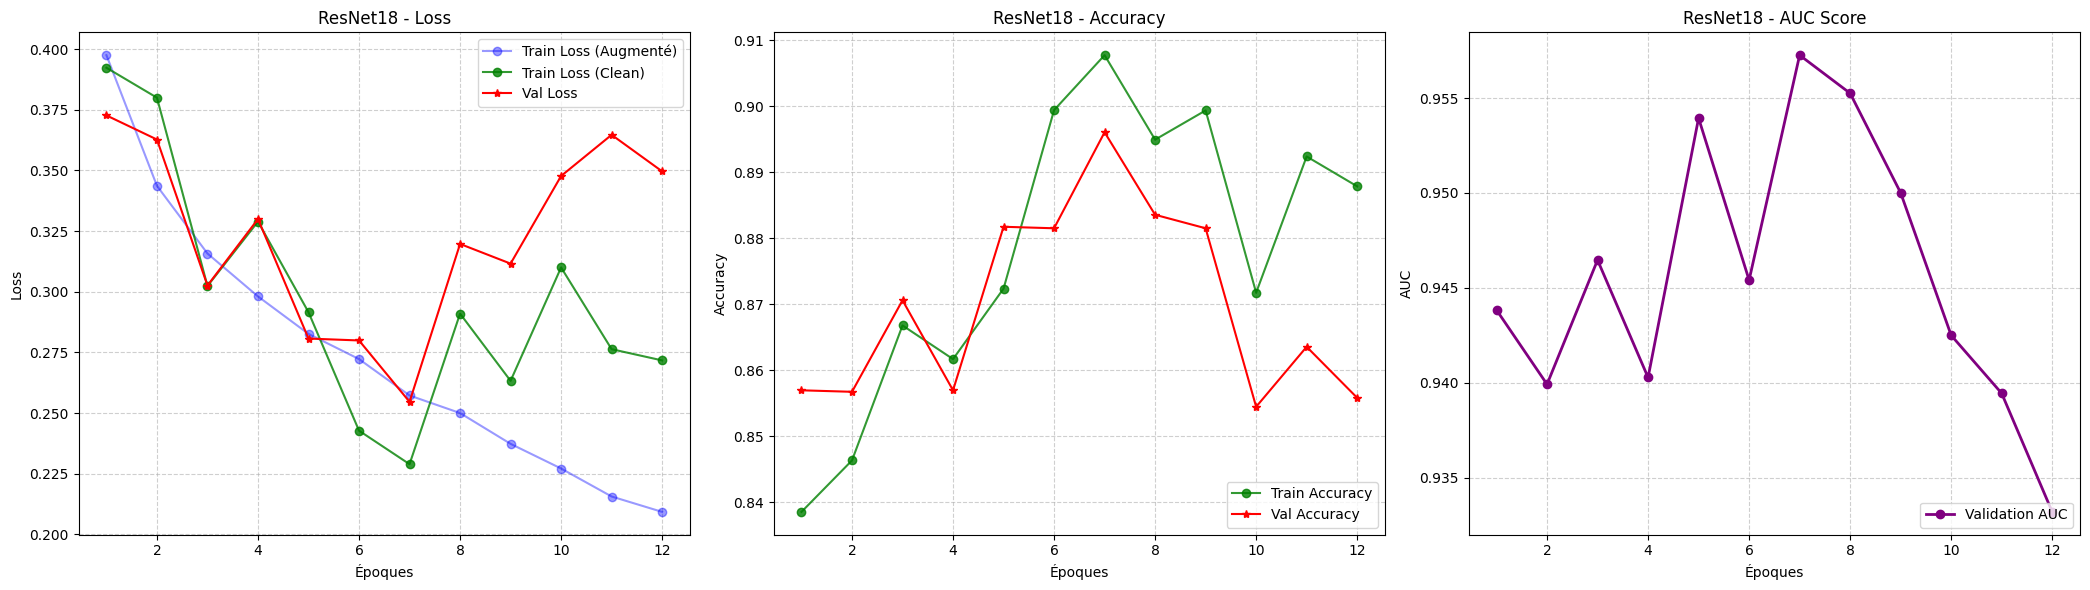

In [ ]:
plot_curves(history_resnet, model_name="ResNet18")

##5.5 Matrice de confusion

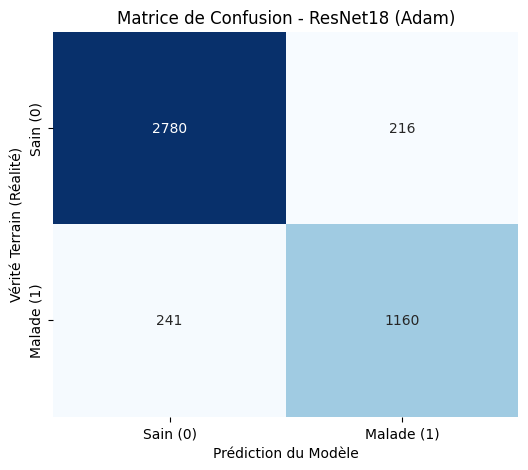

--- Détails pour ResNet18 (Adam) ---
Vrais Négatifs (Sains détectés sains) : 2780
Faux Positifs (Fausses alertes)       : 216
Faux Négatifs (Cancers manqués)       : 241  <-- LE CHIFFRE CRITIQUE
Vrais Positifs (Cancers détectés)     : 1160
-------------------------------------
Sensibilité (Recall) : 0.8280 (Capacité à trouver les malades)
Spécificité          : 0.9279 (Capacité à ne pas alarmer les sains)


In [ ]:
plot_confusion_matrix(resnet, val_loader, device, model_name="ResNet18 (Adam)")

##5.6 Test final

In [ ]:
print("\n--- Évaluation Finale ResNet sur le TEST SET ---")
test_loss_r, test_acc_r, test_f1_r, test_auc_r = evaluation(resnet, test_loader, criterion, device)
error=1-test_acc_r
print(f"ResNet Test Results : Loss:{test_loss_r} AUC: {test_auc_r:.4f} | F1: {test_f1_r:.4f} | Acc: {test_acc_r:.4f}")
print(f"Erreur de généralisation:{error}")


--- Évaluation Finale ResNet sur le TEST SET ---
ResNet Test Results : Loss:0.3227019764339606 AUC: 0.9358 | F1: 0.8016 | Acc: 0.8736
Erreur de généralisation:0.1264225118973722


#6. Comparaison CNN vs ResNet

In [ ]:

plt.figure(figsize=(16, 6))
epochs_cnn = range(1, len(history['val_auc']) + 1)
epochs_resnet = range(1, len(history_resnet['val_auc']) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs_cnn, history['val_auc'], 'b--', label=f'SimpleCNN (Best: {max(history["val_auc"]):.4f})')
plt.plot(epochs_resnet, history_resnet['val_auc'], 'g-', linewidth=2, label=f'ResNet18 (Best: {max(history_resnet["val_auc"]):.4f})')
plt.title('Comparaison : AUC Score')
plt.xlabel('Époques')
plt.ylabel('Validation AUC')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn, history['val_acc'], 'r--', label=f'SimpleCNN (Best: {max(history["val_acc"]):.4f})')
plt.plot(epochs_resnet, history_resnet['val_acc'], 'g-', linewidth=2, label=f'ResNet18 (Best: {max(history_resnet["val_acc"]):.4f})')
plt.title('Comparaison : Accuracy')
plt.xlabel('Époques')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

<Figure size 1600x600 with 0 Axes>

## Tableau des expériences
les valeurs ici sont à refaire pour la reproductibilité

### Synthèse des résultats expérimentaux

| Exp. | Modèle | Optimiseur | Stratégie |Faux negatif| AUC (Val) | Observation / Conclusion |
| :--- | :--- | :--- | :--- |:---| :--- | :--- |
| **1** | SimpleCNN | Adam ($1e^{-4}$) | Baseline || 0.92 | bonne Performance |
| **2** | SimpleCNN | Adam ($1e^{-6}$) | Baseline || 0.91 | bonne Performance |
| **3** | SimpleCNN | Adam + LAWN | Weight Norm || *N/A* | **Échec** : Instabilité numérique (Explosion du gradient / NaN). |
| **4** | SimpleCNN | Adam(1e-4) + BN | Batch Norm || 0.94 | **Stabilisation** réussie. Meilleure généralisation que Exp 1. |
| **5** | SimpleCNN | Adam(5e-6) + BN | Batch Norm || 0.93 | **Stabilisation** réussie. Meilleure généralisation que Exp 1. |
| **6** | SimpleCNN | Adam(1e-6) + BN | Batch Norm || 0.92 | **Stabilisation** réussie. Meilleure généralisation que Exp 1. |
| **4** | ResNet18 | Adam ($1e^{-4}$) | fine tuning complet |241| 0.96 |.... |
| **5** | ResNet18 | SGD+max_lr |fine tuning complet + ReduceLROnPlateau|| 0.95 | Le modèle apprend mieux |
| **6** | **ResNet18** | **SGD (Best LR)** | **Stratégie Cyclique** || **0.94** |  LR optimisé via méthode L. Smith. |

##5.4 eficentnet


In [ ]:
effnet_v2 = models.efficientnet_v2_s(weights='DEFAULT')
for param in effnet_v2.features.parameters():
    param.requires_grad = False
num_ftrs = effnet_v2.classifier[1].in_features
effnet_v2.classifier[1] = nn.Sequential(
    nn.Linear(num_ftrs, 1)
)
effnet_v2 = effnet_v2.to(device)
optimizer_v2 = optim.Adam(effnet_v2.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

print(f"Modèle EfficientNetV2-S prêt.")

Préparation de EfficientNetV2-S...
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 136MB/s]


Modèle EfficientNetV2-S prêt.


In [ ]:



num_epochs = 20
patience = 5
best_val_auc = 0.0
best_model_wts = None
epochs_no_improve = 0
history_eff = {
    "train_loss": [],
    "val_loss": [],
    "val_auc": []
}

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v2, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    effnet_v2.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float()

        optimizer_v2.zero_grad()

        # Forward
        logits = effnet_v2(imgs)
        # EfficientNet sort parfois une shape [Batch, 1], on aplatit
        logits = logits.view(-1)
        loss = criterion(logits, labels)
        # Backward
        loss.backward()
        optimizer_v2.step()
        running_loss += loss.item() * imgs.size(0)
    # Calcul de la loss moyenne sur le train
    epoch_train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc, val_f1, val_auc = evaluate(effnet_v2, val_loader, criterion, device)
    history_eff['train_loss'].append(epoch_train_loss)
    history_eff['val_loss'].append(val_loss)
    history_eff['val_auc'].append(val_auc)

    print(f"Epoch [{epoch}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

    # on fait sheudler et early stopping
    scheduler.step(val_loss)

    # Si on bat le record d'AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_wts = copy.deepcopy(effnet_v2.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping déclenché à l'époque {epoch}. Meilleure AUC : {best_val_auc:.4f}")
        break

# on charge le meilleur modele
if best_model_wts is not None:
    effnet_v2.load_state_dict(best_model_wts)
    print(" Meilleur modèle chargé.")
else:
    print(" Aucun modèle sauvegardé, on garde le dernier état.")

# on evalue sur le test
print("\n--- Résultats Finaux (Test Set) ---")
test_loss, test_acc, test_f1, test_auc = evaluate(effnet_v2, test_loader, criterion, device)
print(f"EfficientNetV2 Test -> AUC: {test_auc:.4f} | F1: {test_f1:.4f} | Acc: {test_acc:.4f}")

NameError: name 'evaluate_with_loss' is not defined

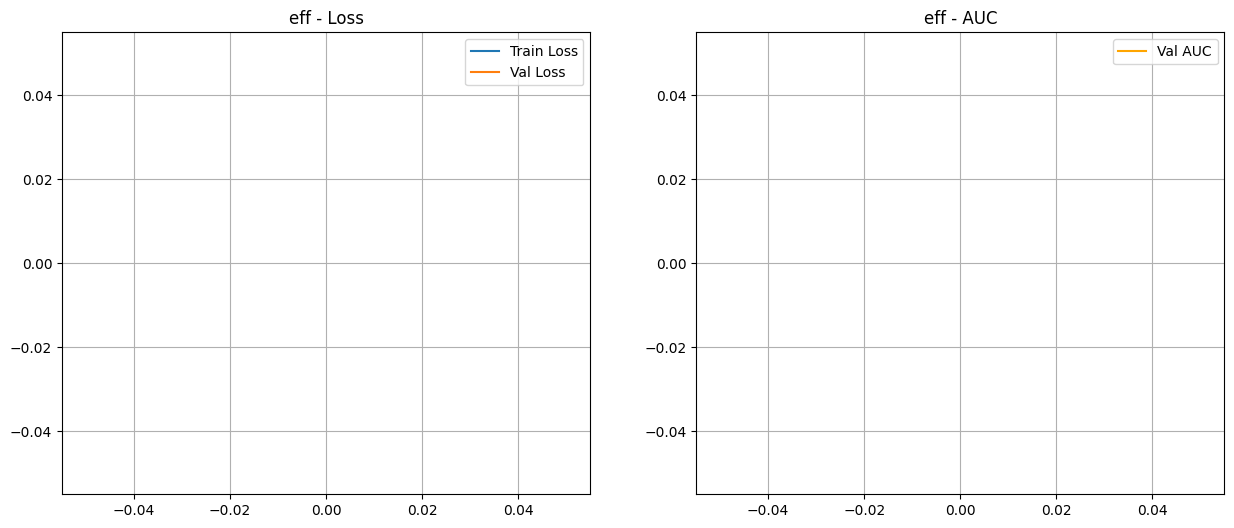

In [ ]:

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history_eff['train_loss'], label='Train Loss')
plt.plot(history_eff['val_loss'], label='Val Loss')
plt.title('eff - Loss')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_eff['val_auc'], label='Val AUC', color='orange')
plt.title('eff - AUC')
plt.legend(); plt.grid(True)
plt.show()

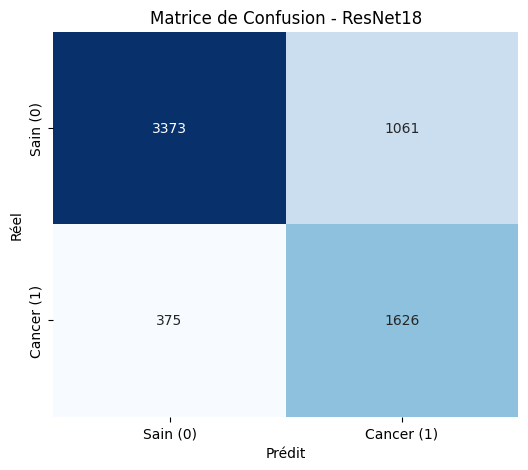

              precision    recall  f1-score   support

        Sain       0.90      0.76      0.82      4434
      Cancer       0.61      0.81      0.69      2001

    accuracy                           0.78      6435
   macro avg       0.75      0.79      0.76      6435
weighted avg       0.81      0.78      0.78      6435

------------------------------
Faux Négatifs (Cancer manqué) : 375
Faux Positifs (Fausse alerte) : 1061


In [ ]:
# j'ai redéfinit le test_loader avec num_workers=0 pour éviter le bug
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# je recupère toutes les prédictions
effnet_v2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = effnet_v2(imgs).view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).int().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Calcul de la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sain (0)', 'Cancer (1)'],
            yticklabels=['Sain (0)', 'Cancer (1)'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title("Matrice de Confusion - ResNet18")
plt.show()
print(classification_report(all_labels, all_preds, target_names=['Sain', 'Cancer']))
print("-" * 30)
print(f"Faux Négatifs (Cancer manqué) : {fn}")
print(f"Faux Positifs (Fausse alerte) : {fp}")

#7. Explicabilité avec Grad-CAM (Saliency Maps)

In [ ]:


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

    def __call__(self, x):
        self.model.zero_grad()
        self.activations = None
        self.gradients = None
        features = self.model.conv1(x)
        features = self.model.bn1(features)
        features = self.model.relu(features)
        features = self.model.maxpool(features)

        features = self.model.layer1(features)
        features = self.model.layer2(features)
        features = self.model.layer3(features)
        features = self.model.layer4(features)
        self.activations = features.detach()
        features_for_grad = features.clone()
        features_for_grad.requires_grad_(True)


        x_after_target = self.model.avgpool(features_for_grad)
        x_after_target = torch.flatten(x_after_target, 1)
        model_output_for_grad = self.model.fc(x_after_target)
        target_logit_for_grad = model_output_for_grad[0]
        self.gradients = torch.autograd.grad(
            outputs=target_logit_for_grad,
            inputs=features_for_grad,
            retain_graph=True
        )[0]

        # ici on genere la heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation_map = self.activations[0] # (Channels, H, W)
        for i in range(activation_map.shape[0]):
            activation_map[i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activation_map, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        # on normalise
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)

        return heatmap




Exemple 1 (Cas Cancer) :


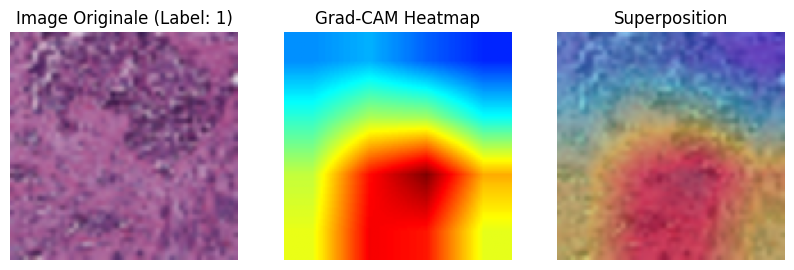

Exemple 2 (Cas Sain) :


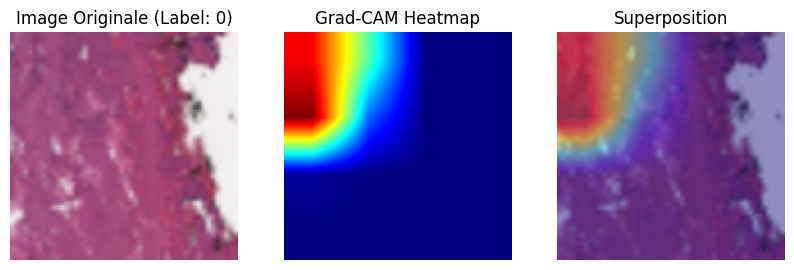

In [ ]:
grad_cam = GradCAM(resnet, resnet.layer4[-1])

def show_gradcam(dataset, idx, model_cam):
    img_tensor, label = dataset[idx]
    img_tensor = img_tensor.unsqueeze(0).to(device)
    heatmap = model_cam(img_tensor)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_display = inv_normalize(img_tensor[0]).cpu().permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)
    heatmap = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    superimposed_img = heatmap * 0.4 + img_display * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 1)


    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title(f"Image Originale (Label: {label})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Superposition")
    plt.axis('off')
    plt.show()

# affichons 2 exemples du Test Set (Cherchons un cas Cancer=1)
print("Exemple 1 (Cas Cancer) :")
#  pour trouver un index positif
idx_pos = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 1][0]
show_gradcam(test_dataset, idx_pos, grad_cam)
print("Exemple 2 (Cas Sain) :")
idx_neg = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 0][0]
show_gradcam(test_dataset, idx_neg, grad_cam)

## 8) Optimisation des hyperparamètres d'un modèle

La sélection d'hyperparamètres  joue un rôle majeur dans l'optimisation des modèles de deep learning. Contrairement aux paramètres du modèle qui sont appris durant l'entraînement, les hyperparamètres (comme le taux d'apprentissage, le nombre de couches cachées, la taille des batch, ou la fonction d'activation) sont définis avant le processus d'apprentissage. Il faut donc choisir avec attention ces valeurs , car elles définissent l'architecture du modèle , et impacte la méthode entraînement .Ils ont un impact majeur sur la capacité du modèle à converger et à généraliser. Le fine tuning (l'optimisation des hyperparamètres )  est alors essentiel pour maximiser les performances du modèle et d'atteindre une précision rapidité et une efficacité optimales sur les tâches ciblées. Nous allons donc développer 2 méthodes de fine tuning : " random search et 'l'optimisation bayésienne " sur des modèles pré entrainées afin de'observer comment les performances sont par rapport à un modèle non fine tuné .

## 8.1) Méthode 1 : Random search


Nous commencerons par la méthode dite de " Random search " . Cette méthode dérive d'une méthode appellée " Grid search " ou l on va sélectionnées des hyper paramêtres dans un dictionnaire , et tester les différentes combinaisons possibles une par une . Cette méthode est efficace mais malheuresement très lentes , si l'on a 5 hyperparamètres a tuné et que l on a 3 possibilité pour chacun , le nombres de combinaisons possible monte à 243 combinaisons . Sur un modèle de deep learning , cela pourrait prendre des heures ce qui n est pas optimal . Pour améliorer ce modèle , au lieu d'essayer toutes les combinaisons possibles , nous n utiliseront qu un faible pourcentage de ces combinaisons , cependant , nous choisiront les combinaisons aléatoirement . On peut se dire que cette méthode peut être beaucoup plus rapide mais cependant pas assez précise , mais on arrive pourtant à déterminer des résultats satisfaisants avec .   

In [ ]:
#on importe les données

images=[]
labels=[]
idx_choose = np.random.choice(np.arange(len(data)), 6000, replace=False).tolist()

for idx in idx_choose:
    i = data[idx]
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(100,100))
        images.append(img_1)
        labels.append(label)
y=[int(label) for label in labels]

In [ ]:
#on définit la fonction pour équilibrer les données

def eq_liste(images, labels):

    indices_0 = [i for i, l in enumerate(labels) if l == 0]
    indices_1 = [i for i, l in enumerate(labels) if l == 1]


    n = min(len(indices_0),len(indices_1))


    indices_a_garder = indices_0[:n] + indices_1[:n]


    images_eq = [images[i] for i in indices_a_garder]
    labels_eq = [labels[i] for i in indices_a_garder]

    return images_eq, labels_eq
X_main,X_test,y_main,y_test=train_test_split(np.array(images),np.array(y),train_size=0.8,shuffle=True)
im,y=eq_liste(X_main,y_main)

#on définit la fonction pour créer les datasets
class MyDataset(Dataset):
    def __init__(self, X_list, y_list, transform=None):
        self.X = [torch.tensor(x.transpose(2, 0, 1), dtype=torch.float32) for x in X_list]
        self.y = torch.tensor([int(label) for label in y_list], dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y


In [ ]:
#on définit les datasets d'entrainement , de la validation et de test
X_train,X_val,y_train,y_val=train_test_split(np.array(im),np.array(y),train_size=0.7,shuffle=True)

dataset_train = MyDataset(X_train, y_train)
dataset_val=MyDataset(X_val,y_val)
dataset_test=MyDataset(X_test,y_test)

In [ ]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([843, 357]))

In [ ]:

#on commence par importer le bibliothèque optuna qui va nous servir a exécuter l algorithme de random search
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.7 MB/s eta 0:00:00


In [ ]:
#on définit la fonction qui va éxécuter le random search
import optuna
from torchvision.models import ResNet50_Weights
def random_s(trial):
    #on définit les paramètres qui seront recherché pour maximiser la précision
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64,128])
    lr =  trial.suggest_categorical('learning_rate', [1e-6, 1e-5, 1e-4, 1e-3])
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])
    dropout =  trial.suggest_categorical('dropout', [0.2, 0.4, 0.6])

    #on définit le modele et on gèle les paramètres que l'on ne va pas optimiser
    model1 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_ftrs = model1.fc.in_features

    for param in model1.parameters():
        param.requires_grad = False

    model1.fc = nn.Sequential(
    nn.Dropout(dropout),
    nn.Linear(num_ftrs, 2))

    for param in model1.fc.parameters():
        param.requires_grad = True

    model1.to(device)

    #on définit les dataloaders qui prendront en compte la taille du batch
    dataloader_tr = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=True)

    #le choix de l'optimiseur
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model1.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optim.Adam(model1.parameters(), lr=lr)

    #la fonction de perte
    criterion = nn.CrossEntropyLoss()

    #on entraine le modele sur le dataloader d'entrainement
    model1.train()
    for epoch in range(20):
        for inputs, labels in dataloader_tr:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    correct, total = 0, 0
    model1.eval()
    #on evalue le modele sur le dataloader de test
    with torch.no_grad():
        for inputs, labels in dataloader_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    return accuracy


study = optuna.create_study(sampler=optuna.samplers.RandomSampler(),direction='maximize')
study.optimize(random_s, n_trials=20)

trials = study.trials[1:]
best_trial = max(trials, key=lambda t: t.value)

print("meilleur paramètres:", study.best_trial.params)
print("précision:", study.best_value)

[I 2025-12-14 19:01:30,460] A new study created in memory with name: no-name-79adea85-5864-4aaf-aca3-c5aa59a665a1


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]
[I 2025-12-14 19:02:18,752] Trial 0 finished with value: 0.7977941176470589 and parameters: {'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'Adam', 'dropout': 0.2}. Best is trial 0 with value: 0.7977941176470589.
[I 2025-12-14 19:02:50,904] Trial 1 finished with value: 0.81125 and parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'SGD', 'dropout': 0.6}. Best is trial 1 with value: 0.81125.
[I 2025-12-14 19:03:30,017] Trial 2 finished with value: 0.8112745098039216 and parameters: {'batch_size': 16, 'learning_rate': 0.001, 'optimizer': 'SGD', 'dropout': 0.2}. Best is trial 2 with value: 0.8112745098039216.
[I 2025-12-14 19:04:03,763] Trial 3 finished with value: 0.51625 and parameters: {'batch_size': 32, 'learning_rate': 1e-06, 'optimizer': 'Adam', 'dropout': 0.8}. Best is trial 2 with value: 0.8112745098039216.
[I 2025-12-14 19:04:36,889] Trial 4 finished with value: 0.828125 and parameters: {'batch_size': 6

meilleur paramètres: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'SGD', 'dropout': 0.8}
précision: 0.828125


In [ ]:
#les meilleurs paramètres qu'on a calculé
study.best_trial.params

{'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'SGD', 'dropout': 0.8}

In [ ]:
train_L=[]
test_L=[]
acc=[]
epochs=20

#après avoir déterminer les meilleurs paramètres on l'entraine et on le test sur un nouveau dataset
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
nn.Dropout(study.best_trial.params['dropout']),
nn.Linear(num_ftrs, 2))

for param in model.fc.parameters():
    param.requires_grad = True

model.to(device)
dataloader_tr = DataLoader(dataset_train, batch_size=int(study.best_trial.params['batch_size']), shuffle=True,drop_last=True)
dataloader_te= DataLoader(dataset_test, batch_size=int(study.best_trial.params['batch_size']), shuffle=False,drop_last=True)

if study.best_trial.params['optimizer']=='SGD':
    optimizer = optim.SGD(model.parameters(), lr=study.best_trial.params['learning_rate'],momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr=study.best_trial.params['learning_rate'])

criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    for inputs, labels in dataloader_tr:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(dataset_train)
    train_L.append(train_loss)

    model.eval()

    correct, total = 0, 0
    test_loss=0.0

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader_te:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss /= len(dataset_test)
    accuracy = correct / total

    test_L.append(test_loss)
    acc.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}]| "
          f"Train Loss: {train_loss:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Accuracy: {accuracy:.4f}"
        )

Epoch [1/15]| Train Loss: 0.6792 | Test Loss: 0.5594 | Accuracy: 0.7682
Epoch [2/15]| Train Loss: 0.5547 | Test Loss: 0.4887 | Accuracy: 0.7873
Epoch [3/15]| Train Loss: 0.4983 | Test Loss: 0.4530 | Accuracy: 0.8056
Epoch [4/15]| Train Loss: 0.4649 | Test Loss: 0.4387 | Accuracy: 0.8108
Epoch [5/15]| Train Loss: 0.4419 | Test Loss: 0.4293 | Accuracy: 0.8108
Epoch [6/15]| Train Loss: 0.4260 | Test Loss: 0.4155 | Accuracy: 0.8151
Epoch [7/15]| Train Loss: 0.4114 | Test Loss: 0.4119 | Accuracy: 0.8099
Epoch [8/15]| Train Loss: 0.4015 | Test Loss: 0.4081 | Accuracy: 0.8099
Epoch [9/15]| Train Loss: 0.3914 | Test Loss: 0.4034 | Accuracy: 0.8108
Epoch [10/15]| Train Loss: 0.3824 | Test Loss: 0.4005 | Accuracy: 0.8090
Epoch [11/15]| Train Loss: 0.3753 | Test Loss: 0.3987 | Accuracy: 0.8151
Epoch [12/15]| Train Loss: 0.3681 | Test Loss: 0.3947 | Accuracy: 0.8151
Epoch [13/15]| Train Loss: 0.3634 | Test Loss: 0.3963 | Accuracy: 0.8168
Epoch [14/15]| Train Loss: 0.3572 | Test Loss: 0.3904 | Accu

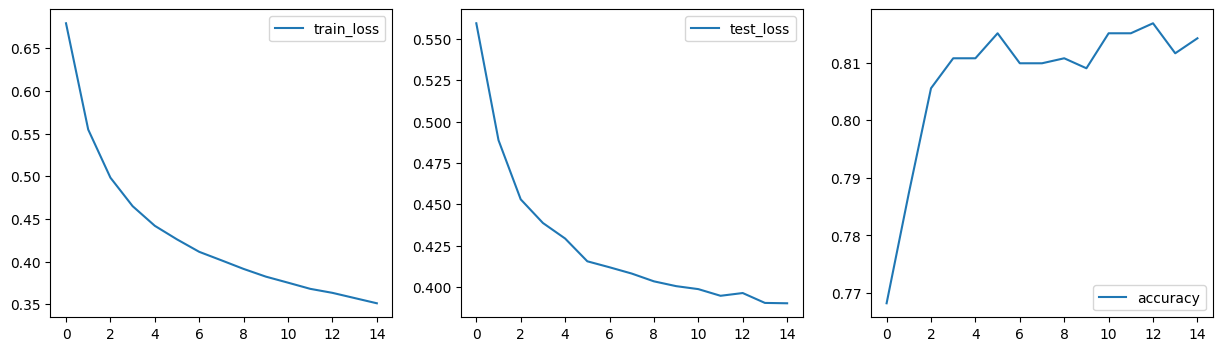

In [ ]:
fig=plt.subplots(ncols=3,figsize=(15,4))
ax1=plt.subplot(1,3,1)
ax1.plot(train_L,label='train_loss')
ax2=plt.subplot(1,3,2)
ax2.plot(test_L,label='test_loss')
ax3=plt.subplot(1,3,3)
ax3.plot(acc,label='accuracy')
ax1.legend( )
ax2.legend()
ax3.legend()

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Matrice de confusion :\n", cm)

Matrice de confusion :
 [[650 154]
 [ 60 288]]


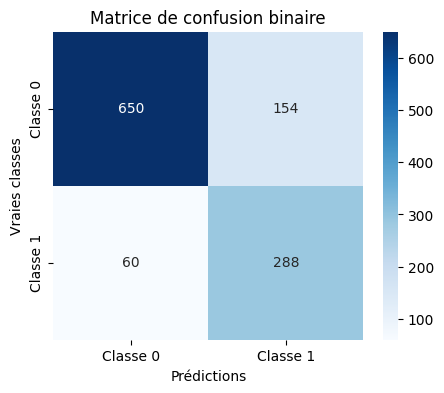

In [ ]:
class_names = ["Classe 0", "Classe 1"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion ")
plt.show()

## 8.2) Méthode 2 : Optimisation Bayésienne

Cependant , cette méthode a des limites , car le choix est aléatoire et on peut rater une combinaison optimal. C'est pour cela qu on utilise une méthode appelé "optimisation bayésienne" . Cela consiste a utilisé d'une approche probabiliste . A l'instar de la recherche aléatoire qui va chercher aléatoirement les combinaisons possible sans prendre en compte les résultats précédents , l'optimisation bayésienne , s'appuit sur les résultats précédents pour approfondir la recherche . Un exemple , si en modifiant un paramètre on obtient de meilleur résultat , alors il ne touchera plus ce paramètre  et modifiera les autres , et ainsi de suite .  

In [ ]:
#on installe la bibliotheque bayesian optimization pour performer l'optimisation bayésienne
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
#on définit les hyperparamètres qu on va optimsier:
bayes_params = {
    "batch_size": (64.,512.), #la taille du batch dans le dataloader
    "lr": (10**(-6),10**(-3)), # le taux d apprentissage , donc la vitesse a laquelle on veut que la descente de gradient aille
    "optimizer_name": (0., 1.),   #le choix de l optimiseur , SGD ou Adam
    "dropout":(0.2,0.8), # le dropout qui correspond au taux de neurones qui vont être désactivés dans la dernière couche , pour éviter l'overfitting
}

In [ ]:
#on définit la fonction qui va chercher les meilleurs paramètres à l aide de l'optimisation bayésienne :



def train_eval_bayesian(batch_size, lr, optimizer_name,dropout):
    batch_size = int(batch_size)
    lr = abs(float(lr))
    optimizer_name = "SGD" if optimizer_name < 0.5 else "Adam"
    dropout = float(dropout)

    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_ftrs = model.fc.in_features

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
    nn.Dropout(dropout),
    nn.Linear(num_ftrs, 2))

    for param in model.fc.parameters():
        param.requires_grad = True

    for name, param in model.named_parameters():
        if "layer4" in name:
            param.requires_grad = True

    model.to(device)
    dataloader_tr = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,drop_last=True)
    dataloader_te= DataLoader(dataset_val, batch_size=batch_size, shuffle=False,drop_last=True)
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(30):
        for inputs, labels in dataloader_tr:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader_te:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
#on définit opti comme la fonction pour faire la recherche d'hyperparamètres
opti = BayesianOptimization(
    f=train_eval_bayesian,
    pbounds=bayes_params,
    random_state=42,
    verbose=2
)

#la recherche de la précision maximal
opti.maximize(
    init_points=5,
    n_iter=10
)

|   iter    |  target   | batch_... |    lr     | optimi... |  dropout  |
-------------------------------------------------------------------------
| 1         | 0.8320346 | 231.79397 | 0.0009507 | 0.7319939 | 0.5591950 |
| 2         | 0.7902255 | 133.89635 | 0.0001568 | 0.0580836 | 0.7197056 |
| 3         | 0.7935435 | 333.29952 | 0.0007083 | 0.0205844 | 0.7819459 |
| 4         | 0.7362385 | 436.93430 | 0.0002131 | 0.1818249 | 0.3100427 |


KeyboardInterrupt: 

In [ ]:
print("les meilleurs paramètres sont:", opti.max)

les meilleurs paramètres sont: {'target': np.float64(0.8386831275720165), 'params': {'batch_size': np.float64(243.7643842367106), 'lr': np.float64(0.000980281133904593), 'optimizer_name': np.float64(0.6089563080919266), 'dropout': np.float64(0.4988212977973343)}}


In [ ]:
max_opt=opti.max

train_L=[]
test_L=[]
acc=[]
epochs=15

#on entraine le modèle et on l'évalue sur les hyperparamètres déterminés
model_t = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
nn.Dropout(max_opt['params']['dropout']),
nn.Linear(num_ftrs, 2))

for param in model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

model.to(device)
dataloader_tr = DataLoader(dataset_train, batch_size=int(max_opt['params']['batch_size']), shuffle=True,drop_last=False)
dataloader_te= DataLoader(dataset_test, batch_size=int(max_opt['params']['batch_size']), shuffle=False,drop_last=False)

if max_opt['params']['optimizer_name']<0.5:
    optimizer = optim.SGD(model.parameters(), lr=max_opt['params']['lr'],momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr=max_opt['params']['lr'])

criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    for inputs, labels in dataloader_tr:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(dataset_train)
    train_L.append(train_loss)

    model.eval()

    correct, total = 0, 0
    test_loss=0.0

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloader_te:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(dataset_test)
    accuracy = correct / total

    test_L.append(test_loss)
    acc.append(accuracy*100)

    print(f"Epoch [{epoch+1}/{epochs}]| "
          f"Train Loss: {train_loss:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Accuracy: {accuracy:.4f}"
        )

Epoch [1/15]| Train Loss: 0.4637 | Test Loss: 0.6379 | Accuracy: 0.7190
Epoch [2/15]| Train Loss: 0.5796 | Test Loss: 0.5646 | Accuracy: 0.6817
Epoch [3/15]| Train Loss: 0.4014 | Test Loss: 0.3801 | Accuracy: 0.8404
Epoch [4/15]| Train Loss: 0.3070 | Test Loss: 0.3953 | Accuracy: 0.8245
Epoch [5/15]| Train Loss: 0.2684 | Test Loss: 0.3651 | Accuracy: 0.8457
Epoch [6/15]| Train Loss: 0.2058 | Test Loss: 0.3594 | Accuracy: 0.8537
Epoch [7/15]| Train Loss: 0.1485 | Test Loss: 0.5885 | Accuracy: 0.8280
Epoch [8/15]| Train Loss: 0.1214 | Test Loss: 0.4418 | Accuracy: 0.8511
Epoch [9/15]| Train Loss: 0.0461 | Test Loss: 0.8296 | Accuracy: 0.8502
Epoch [10/15]| Train Loss: 0.0070 | Test Loss: 2.2474 | Accuracy: 0.8156
Epoch [11/15]| Train Loss: 0.8801 | Test Loss: 0.6812 | Accuracy: 0.5266
Epoch [12/15]| Train Loss: 0.5663 | Test Loss: 0.4512 | Accuracy: 0.7996
Epoch [13/15]| Train Loss: 0.3534 | Test Loss: 0.4143 | Accuracy: 0.8369
Epoch [14/15]| Train Loss: 0.2922 | Test Loss: 0.6290 | Accu

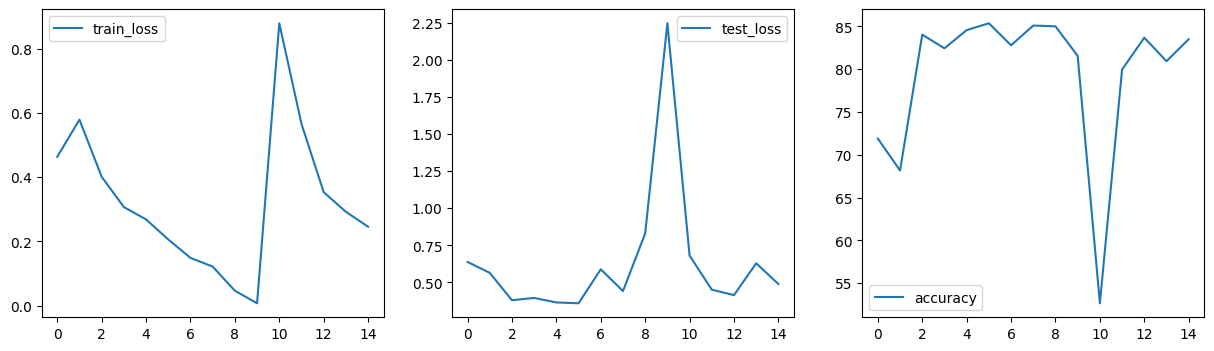

In [ ]:
fig=plt.subplots(ncols=3,figsize=(15,4))
ax1=plt.subplot(1,3,1)
ax1.plot(train_L,label='train_loss')
ax2=plt.subplot(1,3,2)
ax2.plot(test_L,label='test_loss')
ax3=plt.subplot(1,3,3)
ax3.plot(acc,label='accuracy')
ax1.legend( )
ax2.legend()
ax3.legend()

On observe en comparant les 2 méthodes que la méthode bayésienne converge beaucoup plus rapidement que la méthode recherche aléatoire . En effet la méthode bayésienne sur 4 paramètres prend 2 min de temps moins long que la recherche aléatoire . Donc en optimisant beaucoup plus de paramètres sur un dataset encore plus large on a un temps de calcul meilleur pour une meilleur précision .    